In [1]:
import io
import subprocess
import os
import glob

import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
from sklearn.decomposition import PCA
import pickle
import re
import math
import plotnine as pn
import seaborn as sns
import glob
import subprocess
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from numpy import log
from collections import defaultdict,Counter
import re
import statsmodels
import warnings

# !pip install statannotations==0.4.0
# #!pip uninstall statannotations --yes
# from statannotations.Annotator import Annotator

warnings.filterwarnings("ignore")
pd.options.display.max_rows = None
pd.options.display.max_columns=None
pd.options.display.max_colwidth=None
# work_dir="/home/hazhang/projects/LoD_simulation_ColonRectal_09262023"
work_dir="/ghess/pharma/projects/sirius_pharma/hazhang_projects/LoD_simulation_ColonRectal_09262023"

# 217 COSMOS cohort preparation for Epi_TF script developed by Jun Zhao 

In [3]:
#Readin additional newly generated 217 COSMOS samples (10/13/2023). The data is from Threseasa and it's TB results.
df_cosmos_new_ori = pd.read_csv(f"{work_dir}/10132023_COSMOS_217_MRD.csv", header = 0) 
print("Total sample size of the new COSMOS data is " + str(df_cosmos_new_ori.shape[0]) + "\n") 
print("Total unique patient sample size of the new COSMOS data is " + str(df_cosmos_new_ori.GHSampleID.nunique()) + "\n")

#remove some samples that failed the TB 
df_cosmos_new = df_cosmos_new_ori[df_cosmos_new_ori["Sample_status"] == "SUCCESS"]
print("Total sample size of the new COSMOS data and passed the TB is " + str(df_cosmos_new.shape[0]) + "\n") 
print("Total unique patient sample size of new COSMOS data and passed the TB is " + str(df_cosmos_new.GHSampleID.nunique()) + "\n")

#load a file that generated by a query of GHDB based on the df_cosmos_new.GHSampleID list so that the runid can be avaible 
df_cosmos_new_ghdb = pd.read_csv(f"{work_dir}/10132023_COSMOS_217_MRD_GHDB.csv", header = 0) 
print("Total sample size of the new COSMOS data with runid from GHDB is " + str(df_cosmos_new_ghdb.shape[0]) + "\n") 
print("Total unique patient sample size of the new COSMOS data with runid from GHDB is " + str(df_cosmos_new_ghdb.run_sample_id.nunique()) + "\n")

#merge the "runid" information with the 217 COSMOS data
df_cosmos_new.rename(columns={'GHSampleID': 'run_sample_id'}, inplace=True)
df_cosmos_new = df_cosmos_new.merge(df_cosmos_new_ghdb[["run_sample_id", "runid"]], on = "run_sample_id", how = "left")
print("Total sample size of the new COSMOS data with runid from GHDB is " + str(df_cosmos_new.shape[0]) + "\n") 

#add the "maf" column 
df_cosmos_new["maf"] = df_cosmos_new["Percentage"] / 100
df_cosmos_new.head()

Total sample size of the new COSMOS data is 226

Total unique patient sample size of the new COSMOS data is 217

Total sample size of the new COSMOS data and passed the TB is 221

Total unique patient sample size of new COSMOS data and passed the TB is 212

Total sample size of the new COSMOS data with runid from GHDB is 214

Total unique patient sample size of the new COSMOS data with runid from GHDB is 212

Total sample size of the new COSMOS data with runid from GHDB is 223



GHRequestID run_sample_id  Patient_ID Cancertype Tumor_stage  \
0    A0269697    A026969709  COSMOS0055        CRC           I   
1    A0323889    A032388909  COSMOS0391        CRC           I   
2    A0323889    A032388909  COSMOS0391        CRC           I   
3    A0464543    A046454309  COSMOS0184        CRC        IIIB   
4    A0464563    A046456307  COSMOS0219        CRC           I   

  Tumor stage (simplified)           Visit_Name  \
0                        I             3 Months   
1                        I              28 Days   
2                        I              28 Days   
3                      III  1 year and 6 months   
4                        I  1 year and 6 months   

                          CONCAT                    SampleType  \
0             COSMOS00553 Months  Existing Patient, New Sample   
1              COSMOS039128 Days  Existing Patient, New Sample   
2              COSMOS039128 Days  Existing Patient, New Sample   
3  COSMOS01841 year and 6 months  Existing Patient, New Sample   
4  COSMOS02191 year and 6 months  Existing Patient, New Sample   

   1st Aliquot Result Recurrence    Site   Sample Timing  \
0                 NaN         No   Colon  Post-Treatment   
1                 NaN         No   Colon  Post-Treatment   
2                 NaN         No   Colon  Post-Treatment   
3                 NaN         No  Rectal  Post-Treatment   
4                 NaN         No  Rectal  Post-Treatment   

  Pre-Operative Therapy Sample_status Sample_comment ctDNA_detected  \
0                    No       SUCCESS            NaN   Not Detected   
1                    No       SUCCESS            NaN   Not Detected   
2                    No       SUCCESS            NaN   Not Detected   
3                    No       SUCCESS            NaN   Not Detected   
4                    No       SUCCESS            NaN   Not Detected   

  Tumor_methylation_status  Tumor_methylation_score  \
0             Not Detected                      0.0   
1             Not Detected                      0.0   
2             Not Detected                      0.0   
3             Not Detected                      0.0   
4             Not Detected                      0.0   

  Somatic_variant_reportable Variant_type Indel_type Gene  Chromosome  \
0                         No          NaN        NaN  NaN         NaN   
1                         No          NaN        NaN  NaN         NaN   
2                         No          NaN        NaN  NaN         NaN   
3                         No          NaN        NaN  NaN         NaN   
4                         No          NaN        NaN  NaN         NaN   

   Position  Exon Mut_aa Mut_nt Mut_cdna Transcript  Percentage Splice_effect  \
0       NaN   NaN    NaN    NaN      NaN        NaN         NaN           NaN   
1       NaN   NaN    NaN    NaN      NaN        NaN         NaN           NaN   
2       NaN   NaN    NaN    NaN      NaN        NaN         NaN           NaN   
3       NaN   NaN    NaN    NaN      NaN        NaN         NaN           NaN   
4       NaN   NaN    NaN    NaN      NaN        NaN         NaN           NaN   

  COSMIC dbSNP  Mol_count  cfDNA_ng_yield  Plasma_ml_input  \
0    NaN   NaN        NaN          18.980              1.0   
1    NaN   NaN        NaN          16.328              1.0   
2    NaN   NaN        NaN          16.328              1.0   
3    NaN   NaN        NaN          12.584              1.0   
4    NaN   NaN        NaN           7.384              1.0   

   Plasma_ml_remaining Received_date Bloodcoll_date Reported_date  \
0                    0        7/7/20         7/6/20      10/13/23   
1                    0       1/25/21        1/22/21      10/13/23   
2                    0       1/25/21        1/22/21      10/13/23   
3                    0        2/8/22         2/3/22      10/13/23   
4                    0        2/7/22         2/4/22      10/13/23   

            Visit_name                          runid  maf  
0      

In [4]:
#used this as WTF to find all the fc_dir of addtional 217 COSMOS samples 
import glob

# Define the path to the 'flowcentral' directory
fc_all_folder = "/ghds/ivd/flowcentral"

# Add a new column 'fc_dir' to the DataFrame with default empty values
df_cosmos_new['fc_dir'] = ''

# Iterate over each row of the DataFrame
for index, row in df_cosmos_new.iterrows():
    try:
        runid = row["runid"]
        pattern = f"{fc_all_folder}/*{runid}.*"
        
        # Use the glob function to find folders that match the pattern
        folders = glob.glob(pattern)
        
        # Check if any matching folders were found
        if not folders:
            print(f"No suitable folder found for {runid}")
            df_cosmos_new.loc[index, "fc_dir"] = ''
        else:
            folder = folders[0]
            df_cosmos_new.loc[index, "fc_dir"] = folder

    except Exception as e:
        print(f"An error occurred while processing {runid}: {str(e)}")

df_cosmos_new.head()

GHRequestID run_sample_id  Patient_ID Cancertype Tumor_stage  \
0    A0269697    A026969709  COSMOS0055        CRC           I   
1    A0323889    A032388909  COSMOS0391        CRC           I   
2    A0323889    A032388909  COSMOS0391        CRC           I   
3    A0464543    A046454309  COSMOS0184        CRC        IIIB   
4    A0464563    A046456307  COSMOS0219        CRC           I   

  Tumor stage (simplified)           Visit_Name  \
0                        I             3 Months   
1                        I              28 Days   
2                        I              28 Days   
3                      III  1 year and 6 months   
4                        I  1 year and 6 months   

                          CONCAT                    SampleType  \
0             COSMOS00553 Months  Existing Patient, New Sample   
1              COSMOS039128 Days  Existing Patient, New Sample   
2              COSMOS039128 Days  Existing Patient, New Sample   
3  COSMOS01841 year and 6 months  Existing Patient, New Sample   
4  COSMOS02191 year and 6 months  Existing Patient, New Sample   

   1st Aliquot Result Recurrence    Site   Sample Timing  \
0                 NaN         No   Colon  Post-Treatment   
1                 NaN         No   Colon  Post-Treatment   
2                 NaN         No   Colon  Post-Treatment   
3                 NaN         No  Rectal  Post-Treatment   
4                 NaN         No  Rectal  Post-Treatment   

  Pre-Operative Therapy Sample_status Sample_comment ctDNA_detected  \
0                    No       SUCCESS            NaN   Not Detected   
1                    No       SUCCESS            NaN   Not Detected   
2                    No       SUCCESS            NaN   Not Detected   
3                    No       SUCCESS            NaN   Not Detected   
4                    No       SUCCESS            NaN   Not Detected   

  Tumor_methylation_status  Tumor_methylation_score  \
0             Not Detected                      0.0   
1             Not Detected                      0.0   
2             Not Detected                      0.0   
3             Not Detected                      0.0   
4             Not Detected                      0.0   

  Somatic_variant_reportable Variant_type Indel_type Gene  Chromosome  \
0                         No          NaN        NaN  NaN         NaN   
1                         No          NaN        NaN  NaN         NaN   
2                         No          NaN        NaN  NaN         NaN   
3                         No          NaN        NaN  NaN         NaN   
4                         No          NaN        NaN  NaN         NaN   

   Position  Exon Mut_aa Mut_nt Mut_cdna Transcript  Percentage Splice_effect  \
0       NaN   NaN    NaN    NaN      NaN        NaN         NaN           NaN   
1       NaN   NaN    NaN    NaN      NaN        NaN         NaN           NaN   
2       NaN   NaN    NaN    NaN      NaN        NaN         NaN           NaN   
3       NaN   NaN    NaN    NaN      NaN        NaN         NaN           NaN   
4       NaN   NaN    NaN    NaN      NaN        NaN         NaN           NaN   

  COSMIC dbSNP  Mol_count  cfDNA_ng_yield  Plasma_ml_input  \
0    NaN   NaN        NaN          18.980              1.0   
1    NaN   NaN        NaN          16.328              1.0   
2    NaN   NaN        NaN          16.328              1.0   
3    NaN   NaN        NaN          12.584              1.0   
4    NaN   NaN        NaN           7.384              1.0   

   Plasma_ml_remaining Received_date Bloodcoll_date Reported_date  \
0                    0        7/7/20         7/6/20      10/13/23   
1                    0       1/25/21        1/22/21      10/13/23   
2                    0       1/25/21        1/22/21      10/13/23   
3                    0        2/8/22         2/3/22      10/13/23   
4                    0        2/7/22         2/4/22      10/13/23   

            Visit_name                          runid  maf  \
0     

In [5]:
#retrieve S3 caller results of CRC and Lung in BIP run output file {run_sample_id}.msre_all_call.hdr.tsv 
#for Jun's script of epiTF, column "hyper_residual_count_pos_ctrl" is essential
df_cosmos_new_1 = df_cosmos_new.copy()

#initiate columns 
df_cosmos_new_1["methyl_score_LR_CRC"] = np.nan #threshold is 0
df_cosmos_new_1["methyl_score_LR_LUNG"] = np.nan #threshold is 0
df_cosmos_new_1["methyl_score_LR_BREAST"] = np.nan #threshold is 0
df_cosmos_new_1["hyper_residual_count_pos_ctrl"] = np.nan #threshold is 0
df_cosmos_new_1["ctrl_cor_frac"] = np.nan #threshold is 0

# Iterate through rows of the df_met_filtered dataframe
for index, row in df_cosmos_new_1.iterrows():
    run_sample_id = row["run_sample_id"]
    fc_id = row["fc_dir"]
    msre_mr_file = f"{fc_id}/{run_sample_id}/{run_sample_id}.msre_all_call.hdr.tsv"
    
    # Check if the file exists
    if not os.path.exists(msre_mr_file):
        print(f"No file found at {msre_mr_file}")
        continue
    
    # If the file exists, read it into a dataframe
    msre_mr_file_df = pd.read_table(msre_mr_file)
    
    # Filter for rows based on model_name 
    crc_lr_row = msre_mr_file_df[msre_mr_file_df["model_name"] == "CRC"]
    lung_lr_row = msre_mr_file_df[msre_mr_file_df["model_name"] == "LUNG"]
    breast_lr_row = msre_mr_file_df[msre_mr_file_df["model_name"] == "BREAST"]
    
    # If there's a matching row, extract the pred_frac value
    if not crc_lr_row.empty and not lung_lr_row.empty:
        CRC_methyl_score = crc_lr_row["methyl_score"].iloc[0]
        df_cosmos_new_1.loc[index, "methyl_score_LR_CRC"] = CRC_methyl_score
        LUNG_methyl_score = lung_lr_row["methyl_score"].iloc[0]
        df_cosmos_new_1.loc[index, "methyl_score_LR_LUNG"] = LUNG_methyl_score
        BREAST_methyl_score = breast_lr_row["methyl_score"].iloc[0]
        df_cosmos_new_1.loc[index, "methyl_score_LR_BREAST"] = BREAST_methyl_score
        
        #additional columns for Jun's epiTF script
        hyper_residual_count_pos_ctrl_crc = crc_lr_row["hyper_residual_count_pos_ctrl"].iloc[0]
        df_cosmos_new_1.loc[index, "hyper_residual_count_pos_ctrl"] = hyper_residual_count_pos_ctrl_crc
        
        ctrl_cor_frac_crc = crc_lr_row["ctrl_cor_frac"].iloc[0]
        df_cosmos_new_1.loc[index, "ctrl_cor_frac"] = ctrl_cor_frac_crc 
        
df_cosmos_new_1.head()

GHRequestID run_sample_id  Patient_ID Cancertype Tumor_stage  \
0    A0269697    A026969709  COSMOS0055        CRC           I   
1    A0323889    A032388909  COSMOS0391        CRC           I   
2    A0323889    A032388909  COSMOS0391        CRC           I   
3    A0464543    A046454309  COSMOS0184        CRC        IIIB   
4    A0464563    A046456307  COSMOS0219        CRC           I   

  Tumor stage (simplified)           Visit_Name  \
0                        I             3 Months   
1                        I              28 Days   
2                        I              28 Days   
3                      III  1 year and 6 months   
4                        I  1 year and 6 months   

                          CONCAT                    SampleType  \
0             COSMOS00553 Months  Existing Patient, New Sample   
1              COSMOS039128 Days  Existing Patient, New Sample   
2              COSMOS039128 Days  Existing Patient, New Sample   
3  COSMOS01841 year and 6 months  Existing Patient, New Sample   
4  COSMOS02191 year and 6 months  Existing Patient, New Sample   

   1st Aliquot Result Recurrence    Site   Sample Timing  \
0                 NaN         No   Colon  Post-Treatment   
1                 NaN         No   Colon  Post-Treatment   
2                 NaN         No   Colon  Post-Treatment   
3                 NaN         No  Rectal  Post-Treatment   
4                 NaN         No  Rectal  Post-Treatment   

  Pre-Operative Therapy Sample_status Sample_comment ctDNA_detected  \
0                    No       SUCCESS            NaN   Not Detected   
1                    No       SUCCESS            NaN   Not Detected   
2                    No       SUCCESS            NaN   Not Detected   
3                    No       SUCCESS            NaN   Not Detected   
4                    No       SUCCESS            NaN   Not Detected   

  Tumor_methylation_status  Tumor_methylation_score  \
0             Not Detected                      0.0   
1             Not Detected                      0.0   
2             Not Detected                      0.0   
3             Not Detected                      0.0   
4             Not Detected                      0.0   

  Somatic_variant_reportable Variant_type Indel_type Gene  Chromosome  \
0                         No          NaN        NaN  NaN         NaN   
1                         No          NaN        NaN  NaN         NaN   
2                         No          NaN        NaN  NaN         NaN   
3                         No          NaN        NaN  NaN         NaN   
4                         No          NaN        NaN  NaN         NaN   

   Position  Exon Mut_aa Mut_nt Mut_cdna Transcript  Percentage Splice_effect  \
0       NaN   NaN    NaN    NaN      NaN        NaN         NaN           NaN   
1       NaN   NaN    NaN    NaN      NaN        NaN         NaN           NaN   
2       NaN   NaN    NaN    NaN      NaN        NaN         NaN           NaN   
3       NaN   NaN    NaN    NaN      NaN        NaN         NaN           NaN   
4       NaN   NaN    NaN    NaN      NaN        NaN         NaN           NaN   

  COSMIC dbSNP  Mol_count  cfDNA_ng_yield  Plasma_ml_input  \
0    NaN   NaN        NaN          18.980              1.0   
1    NaN   NaN        NaN          16.328              1.0   
2    NaN   NaN        NaN          16.328              1.0   
3    NaN   NaN        NaN          12.584              1.0   
4    NaN   NaN        NaN           7.384              1.0   

   Plasma_ml_remaining Received_date Bloodcoll_date Reported_date  \
0                    0        7/7/20         7/6/20      10/13/23   
1                    0       1/25/21        1/22/21      10/13/23   
2                    0       1/25/21        1/22/21      10/13/23   
3                    0        2/8/22         2/3/22      10/13/23   
4                    0        2/7/22         2/4/22      10/13/23   

            Visit_name                          runid  maf  \
0     

In [48]:
import epicaller
import epicaller.methylation.methyl_caller

def run_mb_crc_caller_wrapper_slurm(sample_meta_df, rundir):
    region_file='/ghds/groups/labdesk/bshih/clinical_genomics/bims_testing/bi-variant-monitoring/rundeck_monitoring_scripts/CRC_methyl_caller_files/v05_classification_space.tsv'
    control_region_file='/ghds/groups/labdesk/bshih/clinical_genomics/bims_testing/bi-variant-monitoring/rundeck_monitoring_scripts/CRC_methyl_caller_files/v05_positive_control_regions.tsv'
    lr_model_file='/ghds/groups/labdesk/bshih/clinical_genomics/bims_testing/bi-variant-monitoring/rundeck_monitoring_scripts/CRC_methyl_caller_files/msre_lr_model.tsv'
    mr_model_file='/ghds/groups/labdesk/bshih/clinical_genomics/bims_testing/bi-variant-monitoring/rundeck_monitoring_scripts/CRC_methyl_caller_files/msre_mr_model.tsv'
    
    for _, row in sample_meta_df.iterrows():
        run_sample_id = row["run_sample_id"]
        fc_dir = row["fc_dir"]
        flowcell_id = row["runid"]
        mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
        # mbd_residual_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_residual_molecules.tsv"
        
        # Check if the molecule file exists
        if not os.path.exists(mbd_hyper_molecules):
            continue
        
        # Check if the job folder exists
        if not(os.path.exists(f"{rundir}/MB_CRC_jobs")):
            os.mkdir(f"{rundir}/MB_CRC_jobs")

        job_file = f"{rundir}/MB_CRC_jobs/MB_call_{run_sample_id}.job" 
        shebang_content = (f"#!/bin/bash\n"
                           f"#SBATCH --job-name=MB_call_{run_sample_id}\n"
                           f"#SBATCH --nodes=1\n"
                           f"#SBATCH --ntasks=1\n"
                           f"#SBATCH --cpus-per-task=1\n"
                           f"#SBATCH --mem=30gb\n"
                           f"#SBATCH --partition=dev\n"
                           f"#SBATCH --time=00:10:00\n"
                           f"#SBATCH --output={rundir}/MB_CRC_jobs/MB_call_{run_sample_id}.log\n\n")
        
        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write("python3 -m epicaller.methylation.methyl_caller " + 
                   f"--hyper-molecule-file {mbd_hyper_molecules} " + 
                   f"--region-file {region_file} " +
                   f"--control-region-file {control_region_file} " + 
                   f"--lr-model-file {lr_model_file} " + 
                   f"--mr-model-file {mr_model_file} " +
                   "--min-frag-len 120 --max-frag-len 240 --min-cg-count 12 --max-cg-count 30 --cutsite-count-cutoff 1 --min-mapq 60 " + 
                   f"--sample-id {run_sample_id} --flowcell-id {runid} --outdir {rundir}/") 
            # print(job_output)    
        os.system(f"sbatch {job_file}")

In [51]:
#run CRC caller
run_mb_crc_caller_wrapper_slurm(df_cosmos_new_1, f"{work_dir}/MB_CRC_caller_COSMOS")

Submitted batch job 69707411
Submitted batch job 69707412
Submitted batch job 69707413
Submitted batch job 69707414
Submitted batch job 69707415
Submitted batch job 69707416
Submitted batch job 69707417
Submitted batch job 69707418
Submitted batch job 69707419
Submitted batch job 69707421
Submitted batch job 69707422
Submitted batch job 69707423
Submitted batch job 69707424
Submitted batch job 69707425
Submitted batch job 69707426
Submitted batch job 69707427
Submitted batch job 69707428
Submitted batch job 69707429
Submitted batch job 69707430
Submitted batch job 69707431
Submitted batch job 69707432
Submitted batch job 69707433
Submitted batch job 69707434
Submitted batch job 69707435
Submitted batch job 69707436
Submitted batch job 69707437
Submitted batch job 69707438
Submitted batch job 69707439
Submitted batch job 69707441
Submitted batch job 69707442
Submitted batch job 69707443
Submitted batch job 69707444
Submitted batch job 69707445
Submitted batch job 69707446
Submitted batc

In [52]:
import epicaller
import epicaller.methylation.methyl_caller

def run_mb_lung_caller_wrapper_slurm(sample_meta_df, rundir):
    region_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/v05_classification_space.tsv' 
    control_region_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/v05_positive_control_regions.tsv' 
    lr_model_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/msre_lr_model.tsv' 
    mr_model_file = '/ghds/pharma/projects/sirius_pharma/mrd_ist/smc_New_MB/lung_candidate_model.mafband_0.01_0.1.devHyper.09-25-23.tsv'
    
    for _, row in sample_meta_df.iterrows():
        run_sample_id = row["run_sample_id"]
        fc_dir = row["fc_dir"]
        flowcell_id = row["runid"]
        mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
        mbd_residual_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_residual_molecules.tsv"
        
        # Check if the molecule file exists
        if not os.path.exists(mbd_hyper_molecules):
            continue
        
        # Check if the job folder exists
        if not(os.path.exists(f"{rundir}/MB_LUNG_jobs")):
            os.mkdir(f"{rundir}/MB_LUNG_jobs")
            
        job_file = f"{rundir}/MB_LUNG_jobs/MB_call_{run_sample_id}.job" 
        shebang_content = (f"#!/bin/bash\n"
                           f"#SBATCH --job-name=MB_call_{run_sample_id}\n"
                           f"#SBATCH --nodes=1\n"
                           f"#SBATCH --ntasks=1\n"
                           f"#SBATCH --cpus-per-task=1\n"
                           f"#SBATCH --mem=30gb\n"
                           f"#SBATCH --partition=dev\n"
                           f"#SBATCH --time=00:10:00\n"
                           f"#SBATCH --output={rundir}/MB_LUNG_jobs/MB_call_{run_sample_id}.log\n\n")
        
        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write("python3 -m epicaller.methylation.methyl_caller " + 
                             f"--hyper-molecule-file {mbd_hyper_molecules} " + 
                             f"--residual-molecule-file {mbd_residual_molecules} " + 
                             f"--region-file {region_file} " +
                             f"--control-region-file {control_region_file} " + 
                             f"--lr-model-file {lr_model_file} " + 
                             f"--mr-model-file {mr_model_file} " +
                             "--min-frag-len 120 --max-frag-len 240 --min-cg-count 12 --max-cg-count 30 --cutsite-count-cutoff 1 --min-mapq 60 " + 
                             f"--sample-id {run_sample_id} --flowcell-id {flowcell_id} --outdir {rundir}/")
            # print(job_output)    
        os.system(f"sbatch {job_file}")


In [53]:
#run the function to generate all the MB Lung caller ouputs
run_mb_lung_caller_wrapper_slurm(df_cosmos_new_1, f"{work_dir}/MB_LUNG_caller_COSMOS")

Submitted batch job 69708051
Submitted batch job 69708052
Submitted batch job 69708053
Submitted batch job 69708054
Submitted batch job 69708055
Submitted batch job 69708056
Submitted batch job 69708057
Submitted batch job 69708058
Submitted batch job 69708059
Submitted batch job 69708060
Submitted batch job 69708061
Submitted batch job 69708062
Submitted batch job 69708063
Submitted batch job 69708064
Submitted batch job 69708065
Submitted batch job 69708066
Submitted batch job 69708067
Submitted batch job 69708068
Submitted batch job 69708069
Submitted batch job 69708070
Submitted batch job 69708071
Submitted batch job 69708072
Submitted batch job 69708073
Submitted batch job 69708074
Submitted batch job 69708075
Submitted batch job 69708076
Submitted batch job 69708077
Submitted batch job 69708078
Submitted batch job 69708079
Submitted batch job 69708080
Submitted batch job 69708081
Submitted batch job 69708082
Submitted batch job 69708083
Submitted batch job 69708084
Submitted batc

In [6]:
#retreive and incoporate MB CRC Lung caller results into the currect data
df_cosmos_new_2 = df_cosmos_new_1.copy()

mb_CRC_caller_result_folder = f"{work_dir}/MB_CRC_caller_COSMOS/"
mb_LUNG_caller_result_folder = f"{work_dir}/MB_CRC_caller_COSMOS/"

df_cosmos_new_2["methyl_score_MB_CRC"] = np.nan
df_cosmos_new_2["methyl_score_MB_LUNG"] = np.nan

# Process mb_score and mb_model_call
for index, row in df_cosmos_new_2.iterrows():
    run_sample_id = row["run_sample_id"]
    
    #get methylation score of MB CRC caller
    crc_msre_mr_file_path = f"{mb_CRC_caller_result_folder}/{run_sample_id}.msre_mr_call.hdr.tsv"
    try:
        crc_msre_mr_file_df = pd.read_table(crc_msre_mr_file_path)
        mb_score = crc_msre_mr_file_df['methyl_score'].iloc[0]
        df_cosmos_new_2.loc[index, "methyl_score_MB_CRC"] = mb_score + 20.2
    except FileNotFoundError:
        print(f"No file found for {run_sample_id}. Assigning np.nan to mb_score.")
    except Exception as e:
        print(f"An error occurred with {run_sample_id}: {str(e)}")

    #get methylation score of MB LUNG caller
    lung_msre_mr_file_path = f"{mb_LUNG_caller_result_folder}/{run_sample_id}.msre_mr_call.hdr.tsv"
    try:
        lung_msre_mr_file_df = pd.read_table(lung_msre_mr_file_path)
        mb_score = lung_msre_mr_file_df['methyl_score'].iloc[0]
        df_cosmos_new_2.loc[index, "methyl_score_MB_LUNG"] = mb_score + 20.03287758915284
    except FileNotFoundError:
        print(f"No file found for {run_sample_id}. Assigning np.nan to mb_score.")
    except Exception as e:
        print(f"An error occurred with {run_sample_id}: {str(e)}")    
    
        
df_cosmos_new_2.head()

GHRequestID run_sample_id  Patient_ID Cancertype Tumor_stage  \
0    A0269697    A026969709  COSMOS0055        CRC           I   
1    A0323889    A032388909  COSMOS0391        CRC           I   
2    A0323889    A032388909  COSMOS0391        CRC           I   
3    A0464543    A046454309  COSMOS0184        CRC        IIIB   
4    A0464563    A046456307  COSMOS0219        CRC           I   

  Tumor stage (simplified)           Visit_Name  \
0                        I             3 Months   
1                        I              28 Days   
2                        I              28 Days   
3                      III  1 year and 6 months   
4                        I  1 year and 6 months   

                          CONCAT                    SampleType  \
0             COSMOS00553 Months  Existing Patient, New Sample   
1              COSMOS039128 Days  Existing Patient, New Sample   
2              COSMOS039128 Days  Existing Patient, New Sample   
3  COSMOS01841 year and 6 months  Existing Patient, New Sample   
4  COSMOS02191 year and 6 months  Existing Patient, New Sample   

   1st Aliquot Result Recurrence    Site   Sample Timing  \
0                 NaN         No   Colon  Post-Treatment   
1                 NaN         No   Colon  Post-Treatment   
2                 NaN         No   Colon  Post-Treatment   
3                 NaN         No  Rectal  Post-Treatment   
4                 NaN         No  Rectal  Post-Treatment   

  Pre-Operative Therapy Sample_status Sample_comment ctDNA_detected  \
0                    No       SUCCESS            NaN   Not Detected   
1                    No       SUCCESS            NaN   Not Detected   
2                    No       SUCCESS            NaN   Not Detected   
3                    No       SUCCESS            NaN   Not Detected   
4                    No       SUCCESS            NaN   Not Detected   

  Tumor_methylation_status  Tumor_methylation_score  \
0             Not Detected                      0.0   
1             Not Detected                      0.0   
2             Not Detected                      0.0   
3             Not Detected                      0.0   
4             Not Detected                      0.0   

  Somatic_variant_reportable Variant_type Indel_type Gene  Chromosome  \
0                         No          NaN        NaN  NaN         NaN   
1                         No          NaN        NaN  NaN         NaN   
2                         No          NaN        NaN  NaN         NaN   
3                         No          NaN        NaN  NaN         NaN   
4                         No          NaN        NaN  NaN         NaN   

   Position  Exon Mut_aa Mut_nt Mut_cdna Transcript  Percentage Splice_effect  \
0       NaN   NaN    NaN    NaN      NaN        NaN         NaN           NaN   
1       NaN   NaN    NaN    NaN      NaN        NaN         NaN           NaN   
2       NaN   NaN    NaN    NaN      NaN        NaN         NaN           NaN   
3       NaN   NaN    NaN    NaN      NaN        NaN         NaN           NaN   
4       NaN   NaN    NaN    NaN      NaN        NaN         NaN           NaN   

  COSMIC dbSNP  Mol_count  cfDNA_ng_yield  Plasma_ml_input  \
0    NaN   NaN        NaN          18.980              1.0   
1    NaN   NaN        NaN          16.328              1.0   
2    NaN   NaN        NaN          16.328              1.0   
3    NaN   NaN        NaN          12.584              1.0   
4    NaN   NaN        NaN           7.384              1.0   

   Plasma_ml_remaining Received_date Bloodcoll_date Reported_date  \
0                    0        7/7/20         7/6/20      10/13/23   
1                    0       1/25/21        1/22/21      10/13/23   
2                    0       1/25/21        1/22/21      10/13/23   
3                    0        2/8/22         2/3/22      10/13/23   
4                    0        2/7/22         2/4/22      10/13/23   

            Visit_name                          runid  maf  \
0     

In [8]:
#generate the forced_TF based on Sai's tutorial
import warnings

# Suppress all warnings
warnings.simplefilter(action='ignore', category=Warning)

def process_samples(df, script_dir, param_path, output_dir):
    """
    Process samples to recalculate the tumor fraction and merge the results.

    Args:
    - df (pandas.DataFrame): Dataframe with sample information.
    - script_dir (str): Directory containing the force-TF.py script.
    - param_path (str): Path to the tumor fraction model parameters.
    - output_dir (str): Directory where the merged output should be saved.

    Returns:
    - merged_file_path (str): Path to the merged output file.
    """
    output_files = []

    for index, row in df.iterrows():
        run_sample_id = row["run_sample_id"]
        runid = row["runid"]
        msre_call_path = f"{row['fc_dir']}/{run_sample_id}/{run_sample_id}.msre_all_call.hdr.tsv"
        
        # Check if the file exists
        if not os.path.exists(msre_call_path):
            print(f"No file found at {msre_call_path}")
            continue
        
        output_file = f"{output_dir}/{run_sample_id}.msre_all_call.with_forceTF.tsv"
        output_files.append(output_file)

        cmd = (f"python3 {script_dir}/force-TF.py " + 
               f"--msre-call {msre_call_path} " + 
               f"--param-path {param_path} " +
               f"--output {output_dir}/{run_sample_id}")
        os.system(cmd)

script_dir = f"{work_dir}/Forced_TF_COSMOS"
param_path = "/ghess/omni_v2/users/schen/epigen/pan-cancer-tf/params/tumor-fraction-model"
output_dir = script_dir

process_samples(df_cosmos_new_2, script_dir, param_path, output_dir)

In [7]:
#retreive and incoporate forced_TF results into the currect data. The algorithm is designed based on LR model so I choose CRC forced_TF
df_cosmos_new_3 = df_cosmos_new_2.copy()

forced_tf_result_folder = f"{work_dir}/Forced_TF_COSMOS/"

df_cosmos_new_3["pred_frac_force"] = np.nan

for index, row in df_cosmos_new_3.iterrows():
    run_sample_id = row["run_sample_id"]
    
    #get pred_frac_force of MB CRC caller
    crc_msre_mr_file_path = f"{forced_tf_result_folder}/{run_sample_id}.msre_all_call.with_forceTF.tsv"
    try:
        crc_msre_mr_file_df = pd.read_table(crc_msre_mr_file_path)
        crc_lr_row = crc_msre_mr_file_df[crc_msre_mr_file_df["model_name"] == "CRC"]
        pred_frac_force_crc = crc_lr_row['pred_frac_force'].iloc[0]
        df_cosmos_new_3.loc[index, "pred_frac_force"] = pred_frac_force_crc
    except FileNotFoundError:
        print(f"No file found for {run_sample_id}. Assigning np.nan to mb_score.")
    except Exception as e:
        print(f"An error occurred with {run_sample_id}: {str(e)}")   
    
        
df_cosmos_new_3.head()

GHRequestID run_sample_id  Patient_ID Cancertype Tumor_stage  \
0    A0269697    A026969709  COSMOS0055        CRC           I   
1    A0323889    A032388909  COSMOS0391        CRC           I   
2    A0323889    A032388909  COSMOS0391        CRC           I   
3    A0464543    A046454309  COSMOS0184        CRC        IIIB   
4    A0464563    A046456307  COSMOS0219        CRC           I   

  Tumor stage (simplified)           Visit_Name  \
0                        I             3 Months   
1                        I              28 Days   
2                        I              28 Days   
3                      III  1 year and 6 months   
4                        I  1 year and 6 months   

                          CONCAT                    SampleType  \
0             COSMOS00553 Months  Existing Patient, New Sample   
1              COSMOS039128 Days  Existing Patient, New Sample   
2              COSMOS039128 Days  Existing Patient, New Sample   
3  COSMOS01841 year and 6 months  Existing Patient, New Sample   
4  COSMOS02191 year and 6 months  Existing Patient, New Sample   

   1st Aliquot Result Recurrence    Site   Sample Timing  \
0                 NaN         No   Colon  Post-Treatment   
1                 NaN         No   Colon  Post-Treatment   
2                 NaN         No   Colon  Post-Treatment   
3                 NaN         No  Rectal  Post-Treatment   
4                 NaN         No  Rectal  Post-Treatment   

  Pre-Operative Therapy Sample_status Sample_comment ctDNA_detected  \
0                    No       SUCCESS            NaN   Not Detected   
1                    No       SUCCESS            NaN   Not Detected   
2                    No       SUCCESS            NaN   Not Detected   
3                    No       SUCCESS            NaN   Not Detected   
4                    No       SUCCESS            NaN   Not Detected   

  Tumor_methylation_status  Tumor_methylation_score  \
0             Not Detected                      0.0   
1             Not Detected                      0.0   
2             Not Detected                      0.0   
3             Not Detected                      0.0   
4             Not Detected                      0.0   

  Somatic_variant_reportable Variant_type Indel_type Gene  Chromosome  \
0                         No          NaN        NaN  NaN         NaN   
1                         No          NaN        NaN  NaN         NaN   
2                         No          NaN        NaN  NaN         NaN   
3                         No          NaN        NaN  NaN         NaN   
4                         No          NaN        NaN  NaN         NaN   

   Position  Exon Mut_aa Mut_nt Mut_cdna Transcript  Percentage Splice_effect  \
0       NaN   NaN    NaN    NaN      NaN        NaN         NaN           NaN   
1       NaN   NaN    NaN    NaN      NaN        NaN         NaN           NaN   
2       NaN   NaN    NaN    NaN      NaN        NaN         NaN           NaN   
3       NaN   NaN    NaN    NaN      NaN        NaN         NaN           NaN   
4       NaN   NaN    NaN    NaN      NaN        NaN         NaN           NaN   

  COSMIC dbSNP  Mol_count  cfDNA_ng_yield  Plasma_ml_input  \
0    NaN   NaN        NaN          18.980              1.0   
1    NaN   NaN        NaN          16.328              1.0   
2    NaN   NaN        NaN          16.328              1.0   
3    NaN   NaN        NaN          12.584              1.0   
4    NaN   NaN        NaN           7.384              1.0   

   Plasma_ml_remaining Received_date Bloodcoll_date Reported_date  \
0                    0        7/7/20         7/6/20      10/13/23   
1                    0       1/25/21        1/22/21      10/13/23   
2                    0       1/25/21        1/22/21      10/13/23   
3                    0        2/8/22         2/3/22      10/13/23   
4                    0        2/7/22         2/4/22      10/13/23   

            Visit_name                          runid  maf  \
0     

In [8]:
#stratify samples by post-op and pre-op
df_cosmos_new_4 = df_cosmos_new_3.drop_duplicates(subset='run_sample_id', keep='first')

#mapping rule
visit_mapping = {
    'Enrollment': 'pre-op',
    '28 days': 'post-op',
    '6 months': 'post-op',
    '28 Days': 'post-op',
    '3 months': 'post-op',
    'Recurrence': 'post-op',
    '9 months': 'post-op',
    '1 year': 'post-op',
    '1 year and 6 months': 'post-op',
    '2 years': 'post-op',
    '14 days': 'post-op',
    '7 days': 'post-op',
    'OTHER': 'post-op',
    '2 years and 6 months': 'post-op',
    '6 Months': 'post-op',
    '3 Months': 'post-op'
}

#create the new 'pre_vs_post' column based on the 'visit' column using the mapping
df_cosmos_new_4['pre_vs_post'] = df_cosmos_new_4['Visit_Name'].map(visit_mapping)
df_cosmos_new_4.pre_vs_post.value_counts()

post-op    119
pre-op      93
Name: pre_vs_post, dtype: int64

In [9]:
#change the working directory
work_dir="/home/hazhang/projects/EpiTF_method_performance_COSMOS_11112023"

In [10]:
#Save the dataframe
df_cosmos_new_4.to_csv(f"{work_dir}/COSMOS_10132023_212samples.csv", index=False)
df_cosmos_new_4.shape

NameError: name 'df_cosmos_unique' is not defined

# Generate epiTFv2alpha developed by Andy 
Confluence page https://guardanthealth.atlassian.net/wiki/spaces/~6318d6f73778a7aadf1a179b/pages/3390276234/epiTF+command+line+documentation

In [9]:
#set up python interpreter based
%env PYTHON=/ghdevhome/home/agross/enviroment/mambaforge/envs/epiTF/bin/python
%env SCRIPT_DIR=/ghdevhome/home/agross/code/epiTF/methylation_classification/scripts/
%env SAMPLE_CMD=$SCRIPT_DIR/run_epiTF.py
%env BATCH_CMD=$SCRIPT_DIR/run_epiTF_batch.py

env: PYTHON=/ghdevhome/home/agross/enviroment/mambaforge/envs/epiTF/bin/python
env: SCRIPT_DIR=/ghdevhome/home/agross/code/epiTF/methylation_classification/scripts/
env: SAMPLE_CMD=$SCRIPT_DIR/run_epiTF.py
env: BATCH_CMD=$SCRIPT_DIR/run_epiTF_batch.py


In [10]:
!echo $PYTHON
!echo $SCRIPT_DIR
!echo $SAMPLE_CMD
!echo $BATCH_CMD

/ghdevhome/home/agross/enviroment/mambaforge/envs/epiTF/bin/python
/ghdevhome/home/agross/code/epiTF/methylation_classification/scripts/
$SCRIPT_DIR/run_epiTF.py
$SCRIPT_DIR/run_epiTF_batch.py


In [12]:
# #single sample test
# mbd_path="/ghds/ivd/flowcentral/230908_A01537_0337_AHCFK3DSX7.0599e5da-d205-4705-b7c0-3777056fd90c.20230910121415/A026969709/A026969709.mbd_hyper_molecules.tsv"
# sample_path="/ghds/ivd/flowcentral/230908_A01537_0337_AHCFK3DSX7.0599e5da-d205-4705-b7c0-3777056fd90c.20230910121415/A026969709"
# out_path="/home/hazhang/projects/EpiTF_method_performance_COSMOS_11112023"
# sample_id="A026969709"

# !$PYTHON ${SCRIPT_DIR}run_epiTF.py "/ghds/ivd/flowcentral/230908_A01537_0337_AHCFK3DSX7.0599e5da-d205-4705-b7c0-3777056fd90c.20230910121415/A026969709/A026969709.mbd_hyper_molecules.tsv" "/ghds/ivd/flowcentral/230908_A01537_0337_AHCFK3DSX7.0599e5da-d205-4705-b7c0-3777056fd90c.20230910121415/A026969709" "/home/hazhang/projects/EpiTF_method_performance_COSMOS_11112023" "A026969709"

In [24]:
#generate epiTF output by TFv2alpha method
df_cosmos_new_5 = df_cosmos_new_4.copy()

out_path = f"{work_dir}/TFv2alpha_COSMOS_ouput"

PYTHON = '/ghdevhome/home/agross/enviroment/mambaforge/envs/epiTF/bin/python'
SCRIPT_DIR = '/ghdevhome/home/agross/code/epiTF/methylation_classification/scripts/'

# Check if the output directory exists, if not, create it
if not os.path.exists(out_path):
    os.makedirs(out_path)

for index, row in df_cosmos_new_5.iterrows():
    fc_dir = row["fc_dir"]
    sample_id = row["run_sample_id"]
    sample_path = f"{fc_dir}/{sample_id}"
    mbd_path = f"{sample_path}/{sample_id}.mbd_hyper_molecules.tsv"

    try:
        # Run the script for each sample
        command = f"{PYTHON} {SCRIPT_DIR}run_epiTF.py {mbd_path} {sample_path} {out_path} {sample_id}"
        os.system(command)
    except FileNotFoundError:
        print(f"No file found for {sample_id}")
    except Exception as e:
        print(f"An error occurred with {sample_id}: {str(e)}")


In [11]:
#retrieve the epiTF ("neat_ratio_newfit3_pan", "epi_tf_fixed_peak_bg3") from TFv2alpha 
#"neat_ratio_newfit3_pan", "epi_tf_fixed_peak_bg3" is considered to be the best TF prediction optimized for true accuracy by Andy
#"epiTFall_pan, epi_tf_fixed_peak_bg3" may be useful for TF change prediction when tracking an individual across time-points by Andy
#"pos_ctrl, epi_tf_fixed_peak_bg3" pos_ctrl: internal positive control measure… analogous to  hyper_methyl_pos_mol_count * 100000
df_cosmos_new_5 = df_cosmos_new_4.copy()
df_cosmos_new_5['epi_tf_fixed_peak_bg3_accuracy'] = None 
df_cosmos_new_5['epi_tf_fixed_peak_bg3_longitudinal'] = None 
df_cosmos_new_5['epi_tf_fixed_peak_bg3_pos_ctrl'] = None 

out_path = f"{work_dir}/TFv2alpha_COSMOS_ouput"

for index, row in df_cosmos_new_5.iterrows():
    sample_id = row["run_sample_id"]
    file_path = f"{out_path}/{sample_id}.epiTF_model_predictions.csv"
    
    try:
        df_temp = pd.read_csv(file_path, index_col=0)
        #value of "epiTFnewfit3_pan", "epi_tf_fixed_peak_bg3"
        value_acc = df_temp.loc["epiTFnewfit3_pan", "epi_tf_fixed_peak_bg3"]
        df_cosmos_new_5.at[index, 'epi_tf_fixed_peak_bg3_accuracy'] = value_acc

        #value of "epiTFall_pan, epi_tf_fixed_peak_bg3"
        value_long = df_temp.loc["epiTFall_pan", "epi_tf_fixed_peak_bg3"]
        df_cosmos_new_5.at[index, 'epi_tf_fixed_peak_bg3_longitudinal'] = value_long
        
        #value of "pos_ctrl, epi_tf_fixed_peak_bg3"
        value_pos_ctrl = df_temp.loc["pos_ctrl", "epi_tf_fixed_peak_bg3"]
        df_cosmos_new_5.at[index, 'epi_tf_fixed_peak_bg3_pos_ctrl'] = value_pos_ctrl
        
    except Exception as e:
        print(f"An error occurred with {sample_id}: {str(e)}")

df_cosmos_new_6 = df_cosmos_new_5.copy()
df_cosmos_new_6.head()

GHRequestID run_sample_id  Patient_ID Cancertype Tumor_stage  \
0    A0269697    A026969709  COSMOS0055        CRC           I   
1    A0323889    A032388909  COSMOS0391        CRC           I   
3    A0464543    A046454309  COSMOS0184        CRC        IIIB   
4    A0464563    A046456307  COSMOS0219        CRC           I   
6    A0464599    A046459909  COSMOS0438        CRC         IIA   

  Tumor stage (simplified)           Visit_Name  \
0                        I             3 Months   
1                        I              28 Days   
3                      III  1 year and 6 months   
4                        I  1 year and 6 months   
6                       II               1 year   

                          CONCAT                    SampleType  \
0             COSMOS00553 Months  Existing Patient, New Sample   
1              COSMOS039128 Days  Existing Patient, New Sample   
3  COSMOS01841 year and 6 months  Existing Patient, New Sample   
4  COSMOS02191 year and 6 months  Existing Patient, New Sample   
6               COSMOS04381 year  Existing Patient, New Sample   

   1st Aliquot Result Recurrence    Site   Sample Timing  \
0                 NaN         No   Colon  Post-Treatment   
1                 NaN         No   Colon  Post-Treatment   
3                 NaN         No  Rectal  Post-Treatment   
4                 NaN         No  Rectal  Post-Treatment   
6                 NaN         No  Rectal  Post-Treatment   

  Pre-Operative Therapy Sample_status Sample_comment ctDNA_detected  \
0                    No       SUCCESS            NaN   Not Detected   
1                    No       SUCCESS            NaN   Not Detected   
3                    No       SUCCESS            NaN   Not Detected   
4                    No       SUCCESS            NaN   Not Detected   
6                    No       SUCCESS            NaN   Not Detected   

  Tumor_methylation_status  Tumor_methylation_score  \
0             Not Detected                      0.0   
1             Not Detected                      0.0   
3             Not Detected                      0.0   
4             Not Detected                      0.0   
6             Not Detected                      0.0   

  Somatic_variant_reportable Variant_type Indel_type Gene  Chromosome  \
0                         No          NaN        NaN  NaN         NaN   
1                         No          NaN        NaN  NaN         NaN   
3                         No          NaN        NaN  NaN         NaN   
4                         No          NaN        NaN  NaN         NaN   
6                         No          NaN        NaN  NaN         NaN   

   Position  Exon Mut_aa Mut_nt Mut_cdna Transcript  Percentage Splice_effect  \
0       NaN   NaN    NaN    NaN      NaN        NaN         NaN           NaN   
1       NaN   NaN    NaN    NaN      NaN        NaN         NaN           NaN   
3       NaN   NaN    NaN    NaN      NaN        NaN         NaN           NaN   
4       NaN   NaN    NaN    NaN      NaN        NaN         NaN           NaN   
6       NaN   NaN    NaN    NaN      NaN        NaN         NaN           NaN   

  COSMIC dbSNP  Mol_count  cfDNA_ng_yield  Plasma_ml_input  \
0    NaN   NaN        NaN          18.980              1.0   
1    NaN   NaN        NaN          16.328              1.0   
3    NaN   NaN        NaN          12.584              1.0   
4    NaN   NaN        NaN           7.384              1.0   
6    NaN   NaN        NaN          10.712              1.0   

   Plasma_ml_remaining Received_date Bloodcoll_date Reported_date  \
0                    0        7/7/20         7/6/20      10/13/23   
1                    0       1/25/21        1/22/21      10/13/23   
3                    0        2/8/22         2/3/22      10/13/23   
4                    0        2/7/22         2/4/22      10/13/23   
6                    0        2/7/22         2/3/22      10/13/23   

            Visit_name                          runid  maf  \
0     

In [12]:
#Save the dataframe
df_cosmos_new_6.to_csv(f"{work_dir}/df_cosmos_new_6.csv", index=False)
df_cosmos_new_6.shape

(212, 57)

# Data Visualizattion

## Data prep

In [ ]:
#df_cosmos_unique was loaded as input data for R script "pan_cancer_nonCBL_COSMOS.ipynb". 
#The subfunction script file "tf_funs_HYZ.R" was used which motified from the original script "tf_funs.R". The changed was adding debugging print lines in function "getNlsPred".

In [2]:
#load input data after incoporating the epiTFnewfit3_pan value generated by R script "pan_cancer_nonCBL_COSMOS.ipynb".
work_dir="/home/hazhang/projects/EpiTF_method_performance_COSMOS_11112023"
df_cosmos_epiTFnew = pd.read_csv(f"{work_dir}/COSMOS_10132023_212samples_epiTFnewfit3_pan.csv", header = 0)

#add epiTFv2alpha "epi_tf_fixed_peak_bg3" (Andy) back to the data together with Sai and Jun's epiTF results together
df_cosmos_new_6 = pd.read_csv(f"{work_dir}/df_cosmos_new_6.csv", header = 0) 
df_cosmos_new_6.rename(columns={'run_sample_id': 'sample_id'}, inplace=True)
df_cosmos_epiTFnew = df_cosmos_epiTFnew.merge(df_cosmos_new_6[["sample_id", "epi_tf_fixed_peak_bg3_accuracy", "epi_tf_fixed_peak_bg3_longitudinal", "epi_tf_fixed_peak_bg3_pos_ctrl"]], on = "sample_id", how = "left")
df_cosmos_epiTFnew['epi_tf_fixed_peak_bg3_accuracy'] = pd.to_numeric(df_cosmos_epiTFnew['epi_tf_fixed_peak_bg3_accuracy'], errors='coerce')
df_cosmos_epiTFnew['epi_tf_fixed_peak_bg3_longitudinal'] = pd.to_numeric(df_cosmos_epiTFnew['epi_tf_fixed_peak_bg3_longitudinal'], errors='coerce')
df_cosmos_epiTFnew['epi_tf_fixed_peak_bg3_pos_ctrl'] = pd.to_numeric(df_cosmos_epiTFnew['epi_tf_fixed_peak_bg3_pos_ctrl'], errors='coerce')

#rename the columns
df_cosmos_epiTFnew = df_cosmos_epiTFnew.rename(columns={
    "pred_frac_force": "epiTF_v0",
    "epiTFnewfit3_pan": "epiTF_v1",
    "epi_tf_fixed_peak_bg3_longitudinal": "epiTF_v2_long",
    "epi_tf_fixed_peak_bg3_accuracy": "epiTF_v2_acc",
    "epi_tf_fixed_peak_bg3_pos_ctrl": "epiTF_v2_pos_ctrl"
})

print("Total COSMOS sample with new epiTF is " + str(df_cosmos_epiTFnew.shape[0]) + "\n") 

df_cosmos_epiTFnew_pre = df_cosmos_epiTFnew[df_cosmos_epiTFnew["pre_vs_post"] == "pre-op"]
print("Total pre-op sample size of COSMOS sample is " + str(df_cosmos_epiTFnew_pre.shape[0]) + "\n") 

df_cosmos_epiTFnew_post = df_cosmos_epiTFnew[df_cosmos_epiTFnew["pre_vs_post"] == "post-op"]
print("Total post-op sample size of COSMOS sample is " + str(df_cosmos_epiTFnew_post.shape[0]) + "\n") 

df_cosmos_epiTFnew.head()

Total COSMOS sample with new epiTF is 212

Total pre-op sample size of COSMOS sample is 93

Total post-op sample size of COSMOS sample is 119



request_id   sample_id  Patient_ID cancer_type Tumor_stage  \
0   A0269697  A026969709  COSMOS0055         CRC           I   
1   A0323889  A032388909  COSMOS0391         CRC           I   
2   A0464543  A046454309  COSMOS0184         CRC        IIIB   
3   A0464563  A046456307  COSMOS0219         CRC           I   
4   A0464599  A046459909  COSMOS0438         CRC         IIA   

  Tumor.stage..simplified.           Visit_Name  \
0                        I             3 Months   
1                        I              28 Days   
2                      III  1 year and 6 months   
3                        I  1 year and 6 months   
4                       II               1 year   

                          CONCAT                    SampleType  \
0             COSMOS00553 Months  Existing Patient, New Sample   
1              COSMOS039128 Days  Existing Patient, New Sample   
2  COSMOS01841 year and 6 months  Existing Patient, New Sample   
3  COSMOS02191 year and 6 months  Existing Patient, New Sample   
4               COSMOS04381 year  Existing Patient, New Sample   

   X1st.Aliquot.Result Recurrence    Site   Sample.Timing  \
0                  NaN         No   Colon  Post-Treatment   
1                  NaN         No   Colon  Post-Treatment   
2                  NaN         No  Rectal  Post-Treatment   
3                  NaN         No  Rectal  Post-Treatment   
4                  NaN         No  Rectal  Post-Treatment   

  Pre.Operative.Therapy Sample_status  Sample_comment ctDNA_detected  \
0                    No       SUCCESS             NaN   Not Detected   
1                    No       SUCCESS             NaN   Not Detected   
2                    No       SUCCESS             NaN   Not Detected   
3                    No       SUCCESS             NaN   Not Detected   
4                    No       SUCCESS             NaN   Not Detected   

  Tumor_methylation_status  Tumor_methylation_score  \
0             Not Detected                      0.0   
1             Not Detected                      0.0   
2             Not Detected                      0.0   
3             Not Detected                      0.0   
4             Not Detected                      0.0   

  Somatic_variant_reportable Variant_type Indel_type Gene  Chromosome  \
0                         No          NaN        NaN  NaN         NaN   
1                         No          NaN        NaN  NaN         NaN   
2                         No          NaN        NaN  NaN         NaN   
3                         No          NaN        NaN  NaN         NaN   
4                         No          NaN        NaN  NaN         NaN   

   Position  Exon Mut_aa Mut_nt Mut_cdna Transcript  Percentage Splice_effect  \
0       NaN   NaN    NaN    NaN      NaN        NaN         NaN           NaN   
1       NaN   NaN    NaN    NaN      NaN        NaN         NaN           NaN   
2       NaN   NaN    NaN    NaN      NaN        NaN         NaN           NaN   
3       NaN   NaN    NaN    NaN      NaN        NaN         NaN           NaN   
4       NaN   NaN    NaN    NaN      NaN        NaN         NaN           NaN   

  COSMIC dbSNP  Mol_count  cfDNA_ng_yield  Plasma_ml_input  \
0    NaN   NaN        NaN          18.980              1.0   
1    NaN   NaN        NaN          16.328              1.0   
2    NaN   NaN        NaN          12.584              1.0   
3    NaN   NaN        NaN           7.384              1.0   
4    NaN   NaN        NaN          10.712              1.0   

   Plasma_ml_remaining Received_date Bloodcoll_date Reported_date  \
0                    0        7/7/20         7/6/20      10/13/23   
1                    0       1/25/21        1/22/21      10/13/23   
2                    0        2/8/22         2/3/22      10/13/23   
3                    0        2/7/22         2/4/22      10/13/23   
4                    0        2/7/22         2/3/22      10/13/23   

            Visit_name                          runid  maf  \
0     

In [3]:
#screen for MB CRC pos and ctDNA detected pre-op samples
df_cosmos_new_pos = df_cosmos_epiTFnew_pre[df_cosmos_epiTFnew_pre["methyl_score_MB_CRC"] > 0]
print("Total sample size of the pre-op new COSMOS MB rerun data with positive MB CRC epicaller is " + str(df_cosmos_new_pos.shape[0]) + "\n")

#filter out samples that have detected ctDNA
df_cosmos_new_pos_detected = df_cosmos_new_pos[df_cosmos_new_pos["ctDNA_detected"] == "Detected"]
print("Total sample size of the pre-op new COSMOS MB rerun data with positive MB CRC epicaller and detected ctDNA is " + str(df_cosmos_new_pos_detected.shape[0]) + "\n")

Total sample size of the pre-op new COSMOS MB rerun data with positive MB CRC epicaller is 59

Total sample size of the pre-op new COSMOS MB rerun data with positive MB CRC epicaller and detected ctDNA is 59



In [4]:
#load 217 COSMOS TB CORE module report (done by Patric) since MRD report not all methylation detected samples have somatic and its maf reported (due to TVF filter)
df_Infinity_core_COSMOS = pd.read_csv(f"{work_dir}/20230919_COS_IST08_Infinity_04_post_tb_tb_changed_RUO_report.csv", header = 1)

#drop duplication
df_Infinity_core_COSMOS_1 = df_Infinity_core_COSMOS.drop_duplicates(subset='GHSampleID', keep='first')
print("Total sample size of the new COSMOS data is " + str(df_Infinity_core_COSMOS_1.shape[0]) + "\n") 
print("Total unique patient sample size of the new COSMOS data is " + str(df_Infinity_core_COSMOS_1.GHSampleID.nunique()) + "\n")

#add "Max_percentage" column to the df_cosmos_new_pos_detected
df_Infinity_core_COSMOS_1.rename(columns={'GHSampleID': 'sample_id'}, inplace=True)

df_cosmos_new_pos_detected = df_cosmos_new_pos_detected.merge(df_Infinity_core_COSMOS_1[["sample_id", "Max_percentage"]], on = "sample_id", how = "left")
df_cosmos_new_pos_detected.head()

Total sample size of the new COSMOS data is 217

Total unique patient sample size of the new COSMOS data is 217



request_id   sample_id  Patient_ID cancer_type Tumor_stage  \
0   A0284439  A028443910  COSMOS0234         CRC         IIA   
1   A0292747  A029274710  COSMOS0273         CRC           I   
2   A0293095  A029309510  COSMOS0272         CRC           I   
3   A0294525  A029452510  COSMOS0275         CRC        IIIB   
4   A0295171  A029517110  COSMOS0271         CRC        IIIB   

  Tumor.stage..simplified.  Visit_Name                CONCAT  \
0                       II  Enrollment  COSMOS0234Enrollment   
1                        I  Enrollment  COSMOS0273Enrollment   
2                        I  Enrollment  COSMOS0272Enrollment   
3                      III  Enrollment  COSMOS0275Enrollment   
4                      III  Enrollment  COSMOS0271Enrollment   

                     SampleType  X1st.Aliquot.Result Recurrence    Site  \
0  Existing Patient, New Sample                  NaN         No  Rectal   
1  Existing Patient, New Sample                  NaN         No   Colon   
2  Existing Patient, New Sample                  NaN         No   Colon   
3  Existing Patient, New Sample                  NaN         No  Rectal   
4  Existing Patient, New Sample                  NaN        Yes   Colon   

   Sample.Timing Pre.Operative.Therapy Sample_status  Sample_comment  \
0  Pre-treatment                    No       SUCCESS             NaN   
1  Pre-treatment                    No       SUCCESS             NaN   
2  Pre-treatment                    No       SUCCESS             NaN   
3  Pre-treatment                    No       SUCCESS             NaN   
4  Pre-treatment                    No       SUCCESS             NaN   

  ctDNA_detected Tumor_methylation_status  Tumor_methylation_score  \
0       Detected                 Detected                 0.003925   
1       Detected                 Detected                 0.001156   
2       Detected                 Detected                 0.001853   
3       Detected                 Detected                 0.000979   
4       Detected                 Detected                 0.004448   

  Somatic_variant_reportable Variant_type Indel_type Gene  Chromosome  \
0                         No          NaN        NaN  NaN         NaN   
1                         No          NaN        NaN  NaN         NaN   
2                         No          NaN        NaN  NaN         NaN   
3                         No          NaN        NaN  NaN         NaN   
4                        Yes        Indel   Deletion  APC         5.0   

      Position  Exon Mut_aa Mut_nt      Mut_cdna   Transcript  Percentage  \
0          NaN   NaN    NaN    NaN           NaN          NaN         NaN   
1          NaN   NaN    NaN    NaN           NaN          NaN         NaN   
2          NaN   NaN    NaN    NaN           NaN          NaN         NaN   
3          NaN   NaN    NaN    NaN           NaN          NaN         NaN   
4  112155042.0  10.0    NaN   GT>G  c.1312+2delT  NM_000038.6     1.80863   

          Splice_effect COSMIC dbSNP  Mol_count  cfDNA_ng_yield  \
0                   NaN    NaN   NaN        NaN          17.368   
1                   NaN    NaN   NaN        NaN          10.712   
2                   NaN    NaN   NaN        NaN          14.196   
3                   NaN    NaN   NaN        NaN          22.984   
4  splice_donor_variant    NaN   NaN     1822.0          17.732   

   Plasma_ml_input  Plasma_ml_remaining Received_date Bloodcoll_date  \
0              1.0                    0        9/3/20         9/2/20   
1              1.0                    0       10/6/20        10/5/20   
2              1.0                    0       10/7/20        10/2/20   
3              1.0                    0      10/13/20        10/9/20   
4              1.0                    0      10/15/20       10/14/20   

  Reported_date  Visit_name                          runid       maf  \
0      10/13/23  Enrollment  230913_A01835_0126_AHK727DSX7       NaN   
1      10/13/23  Enrollment  230913_A01835_01

In [5]:
#load MRD report to get more strigent somatic variants
df_Infinity_MRD_COSMOS = pd.read_csv(f"{work_dir}/20230919_COS_IST08_Infinity_04_post_tb_tb_changed_RUO_report_MRD.csv", header = 0)

# Sort the DataFrame based on 'Percentage' in descending order to have the highest value at the top for each group
df_Infinity_MRD_COSMOS_1 = df_Infinity_MRD_COSMOS[df_Infinity_MRD_COSMOS["Somatic_variant_reportable"] == "Yes"]
df_Infinity_MRD_COSMOS_2 = df_Infinity_MRD_COSMOS_1.sort_values(by='Percentage', ascending=False)

# Drop duplicate
df_Infinity_MRD_COSMOS_2 = df_Infinity_MRD_COSMOS_2.drop_duplicates(subset='GHSampleID', keep='first')
print("Total sample size of the MRD COSMOS data with TVF somatic variant is " + str(df_Infinity_MRD_COSMOS_2.shape[0]) + "\n") 
print("Total unique patient sample size of the MRD COSMOS data with TVF somatic variant is " + str(df_Infinity_MRD_COSMOS_2.GHSampleID.nunique()) + "\n")

#add "Percentage" column to the df_cosmos_new_pos_detected
df_Infinity_MRD_COSMOS_2.rename(columns={
    'GHSampleID': 'sample_id',
    'Gene': 'TVF_Gene',
    'Mut_aa': 'TVF_Mut_aa',
    'Percentage': 'TVF_Percentage'
}, inplace=True)

df_cosmos_new_pos_detected_tvf = df_cosmos_new_pos_detected.merge(df_Infinity_MRD_COSMOS_2[["sample_id", "TVF_Gene", "TVF_Mut_aa", "TVF_Percentage"]], on = "sample_id", how = "left")
df_cosmos_new_pos_detected_tvf = df_cosmos_new_pos_detected_tvf[df_cosmos_new_pos_detected_tvf["TVF_Percentage"].notna()]
print("Total sample size of the MRD COSMOS data with TVF somatic variant with TFv2alpha is " + str(df_cosmos_new_pos_detected_tvf.shape[0]) + "\n") 
df_cosmos_new_pos_detected_tvf.head()

Total sample size of the MRD COSMOS data with TVF somatic variant is 22

Total unique patient sample size of the MRD COSMOS data with TVF somatic variant is 22

Total sample size of the MRD COSMOS data with TVF somatic variant with TFv2alpha is 19



request_id   sample_id  Patient_ID cancer_type Tumor_stage  \
4    A0295171  A029517110  COSMOS0271         CRC        IIIB   
9    A0344477  A034447710  COSMOS0493         CRC        IIIB   
11   A0344816  A034481610  COSMOS0496         CRC        IIIB   
13   A0349378  A034937810  COSMOS0506         CRC           I   
17   A0323895  A032389510  COSMOS0374         CRC         IIA   

   Tumor.stage..simplified.  Visit_Name                CONCAT  \
4                       III  Enrollment  COSMOS0271Enrollment   
9                       III  Enrollment  COSMOS0493Enrollment   
11                      III  Enrollment  COSMOS0496Enrollment   
13                        I  Enrollment  COSMOS0506Enrollment   
17                       II  Enrollment  COSMOS0374Enrollment   

                      SampleType  X1st.Aliquot.Result Recurrence    Site  \
4   Existing Patient, New Sample                  NaN        Yes   Colon   
9   Existing Patient, New Sample                  NaN         No   Colon   
11  Existing Patient, New Sample                  NaN         No  Rectal   
13  Existing Patient, New Sample                  NaN         No   Colon   
17  Existing Patient, New Sample                  NaN         No   Colon   

      Sample.Timing Pre.Operative.Therapy Sample_status  Sample_comment  \
4     Pre-treatment                    No       SUCCESS             NaN   
9     Pre-treatment                    No       SUCCESS             NaN   
11  Pre-Op/Post ACT                   Yes       SUCCESS             NaN   
13    Pre-treatment                    No       SUCCESS             NaN   
17    Pre-treatment                    No       SUCCESS             NaN   

   ctDNA_detected Tumor_methylation_status  Tumor_methylation_score  \
4        Detected                 Detected                 0.004448   
9        Detected                 Detected                 0.001849   
11       Detected                 Detected                 0.038846   
13       Detected                 Detected                 0.001995   
17       Detected                 Detected                 0.003444   

   Somatic_variant_reportable Variant_type Indel_type Gene  Chromosome  \
4                         Yes        Indel   Deletion  APC         5.0   
9                         Yes        Indel   Deletion  APC         5.0   
11                        Yes          SNV        NaN  APC         5.0   
13                        Yes          SNV        NaN  APC         5.0   
17                        Yes        Indel  Insertion  APC         5.0   

       Position  Exon   Mut_aa Mut_nt          Mut_cdna   Transcript  \
4   112155042.0  10.0      NaN   GT>G      c.1312+2delT  NM_000038.6   
9   112179597.0  16.0  H2770fs  AAC>A  c.8310_8311delCA  NM_000038.6   
11  112173917.0  16.0    R876*    C>T         c.2626C>T  NM_000038.6   
13  112175390.0  16.0   Q1367*    C>T         c.4099C>T  NM_000038.6   
17  112175265.0  16.0  V1326fs   C>CA        c.3975dupA  NM_000038.6   

    Percentage         Splice_effect        COSMIC        dbSNP  Mol_count  \
4     1.808630  splice_donor_variant           NaN          NaN     1822.0   
9     0.369375                   NaN           NaN          NaN     3334.0   
11    1.923520                   NaN  COSV57320538  rs121913333     4433.0   
13    0.153257                   NaN  COSV57323776  rs121913328     1335.0   
17    0.470286                   NaN           NaN          NaN     2592.0   

    cfDNA_ng_yield  Plasma_ml_input  Plasma_ml_remaining Received_date  \
4           17.732              1.0                    0      10/15/20   
9           36.816              1.0                    0        4/5/21   
11          27.820              1.0                    0        4/7/21   
13           9.776              1.0                    0       4/22/21   
17          18.928              1.0                    0       1/25/21   

   Bloodcoll_date Reported_date  Visit_name                          runid  \
4        10/14/2

## Boxplot to compare MB CRC score of pre-op COSMOS across different cancer stage

Stage I: n = 14, Median: 3.04e+00, CI: [2.20e+00, 7.21e+00]
Stage II: n = 20, Median: 5.95e+00, CI: [4.75e+00, 1.35e+01]
Stage III: n = 20, Median: 1.10e+01, CI: [7.63e+00, 1.72e+01]
Stage IV: n = 5, Median: 1.52e+01, CI: [3.73e+00, 2.52e+01]
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

I vs. II: t-test independent samples, P_val:1.100e-01 t=-1.644e+00
II vs. III: t-test independent samples, P_val:2.918e-01 t=-1.069e+00
III vs. IV: t-test independent samples, P_val:6.852e-01 t=-4.106e-01
I vs. III: t-test independent samples, P_val:1.242e-02 t=-2.649e+00
II vs. IV: t-test independent samples, P_val:2.564e-01 t=-1.164e+00
I vs. IV: t-test independent samples, P_val:4.119e-03 t=-3.312e+00


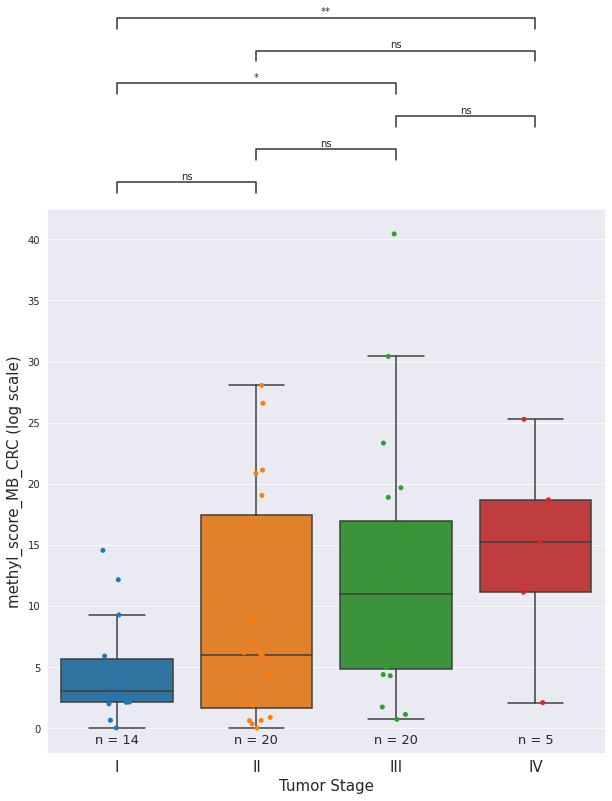

In [7]:
from statannotations.Annotator import Annotator

# #plot the MB CRC score by stage in pre-op COSMOS
# plot_order = ["I", "II", "III", "IV"]
# fig, ax0 = plt.subplots(nrows=1, figsize=(10, 10)) 
# sns.boxplot(data=df_cosmos_new_pos_detected, x="Tumor.stage..simplified.", y="methyl_score_MB_CRC", order = plot_order, ax=ax0)
# ax0.set_xlabel('Tumor Stage', fontsize=15)
# ax0.set_ylabel('MB CRC Score', fontsize=15)

# plt.show()

def boxplot_simple_stage(df, x_col):
    fig, ax0 = plt.subplots(nrows=1, figsize=(10, 10)) 

    sns.set_style('darkgrid')
    plot_order = ["I", "II", "III", "IV"]

    # Boxplot
    sns.boxplot(data=df, x="Tumor.stage..simplified.", y=x_col, showfliers=False, order=plot_order, ax=ax0)
    sns.stripplot(data=df, x="Tumor.stage..simplified.", y=x_col, jitter=True, size=5, dodge=True, ax=ax0, linewidth=0.5, edgecolor='none', order=plot_order)  
    
    # ax0.set_yscale("log")  
    #This 0.00006 parameter is used to adjust the position of sample n indication
    #This number needs to be adjusted otherwise may encounter ValueError of Image size
    y_offset = df[x_col].min() - 1
    
    stages = df['Tumor.stage..simplified.'].unique()
    for i, stage in enumerate(plot_order):
        subset = df[df['Tumor.stage..simplified.'] == stage]
        n = len(subset)
        median = np.median(subset[x_col])
        ci_low, ci_high = stats.t.interval(0.95, len(subset)-1, loc=np.mean(subset[x_col]), scale=stats.sem(subset[x_col]))
        ax0.text(i, y_offset, f'n = {n}', ha='center', va='center', fontsize=13)
        print(f'Stage {stage}: n = {n}, Median: {median:.2e}, CI: [{ci_low:.2e}, {ci_high:.2e}]')

    pairs = [
        ("I", "II"),
        ("I", "III"),
        ("I", "IV"),
        ("II", "III"),
        ("II", "IV"),
        ("III", "IV")
    ]
    
    annotator = Annotator(ax=ax0, pairs=pairs, data=df, x='Tumor.stage..simplified.', y=x_col, order=plot_order)
    annotator.configure(test='t-test_ind', text_format='star', loc='outside')
    annotator.apply_and_annotate()

    # plt.title(f'{x_col} by Stage on pre-op COSMOS (MB CRC pos & ctDNA detected)', fontsize=15)
    ax0.set_xlabel('Tumor Stage', fontsize=15)
    ax0.set_ylabel(f'{x_col} (log scale)', fontsize=15)
    ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=15)

    plt.show()
    
boxplot_simple_stage(df_cosmos_new_pos_detected, 'methyl_score_MB_CRC')

## Boxplot to compare different epiTF methods of pre-op COSMOS across different cancer stage

Stage I: n = 14, Median: 1.42e-03, CI: [1.23e-03, 1.87e-03]
Stage II: n = 20, Median: 2.17e-03, CI: [1.85e-03, 3.58e-03]
Stage III: n = 20, Median: 1.91e-03, CI: [8.12e-04, 8.76e-03]
Stage IV: n = 5, Median: 1.83e-03, CI: [2.93e-04, 5.90e-03]
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

I vs. II: t-test independent samples, P_val:2.913e-02 t=-2.284e+00
II vs. III: t-test independent samples, P_val:2.931e-01 t=-1.066e+00
III vs. IV: t-test independent samples, P_val:6.675e-01 t=4.352e-01
I vs. III: t-test independent samples, P_val:1.662e-01 t=-1.417e+00
II vs. IV: t-test independent samples, P_val:6.961e-01 t=-3.956e-01
I vs. IV: t-test independent samples, P_val:2.403e-02 t=-2.477e+00


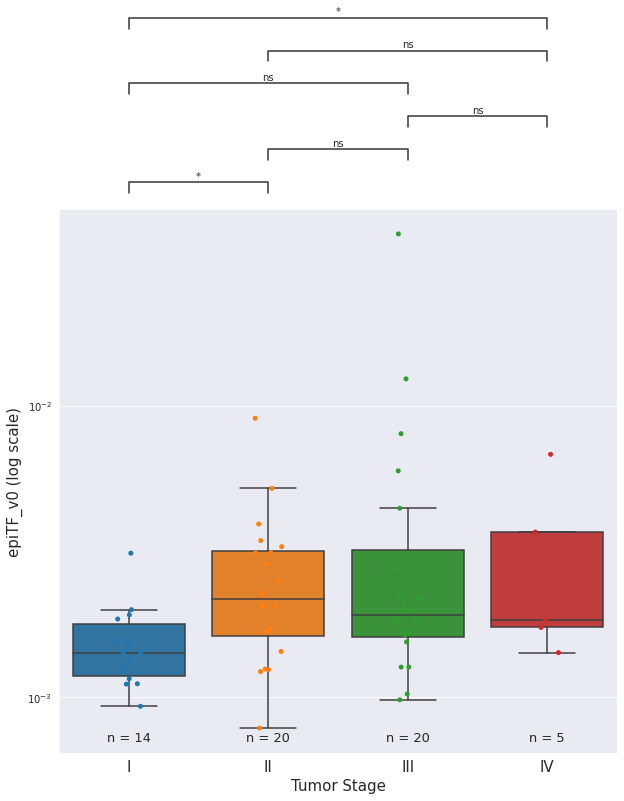

Stage I: n = 14, Median: 9.45e-04, CI: [7.70e-04, 1.38e-03]
Stage II: n = 20, Median: 1.59e-03, CI: [1.20e-03, 3.33e-03]
Stage III: n = 20, Median: 1.49e-03, CI: [5.11e-04, 7.75e-03]
Stage IV: n = 5, Median: 1.44e-03, CI: [-1.07e-04, 4.82e-03]
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

I vs. II: t-test independent samples, P_val:6.519e-02 t=-1.910e+00
II vs. III: t-test independent samples, P_val:3.069e-01 t=-1.036e+00
III vs. IV: t-test independent samples, P_val:6.209e-01 t=5.014e-01
I vs. III: t-test independent samples, P_val:1.518e-01 t=-1.468e+00
II vs. IV: t-test independent samples, P_val:9.346e-01 t=-8.296e-02
I vs. IV: t-test independent samples, P_val:3.455e-02 t=-2.298e+00


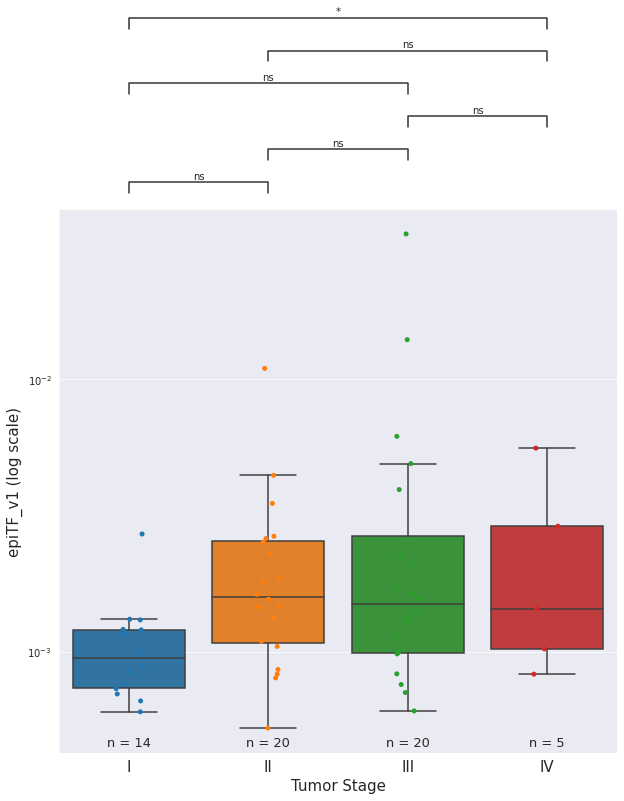

In [7]:
from statannotations.Annotator import Annotator

def boxplot_simple(df, x_col):
    fig, ax0 = plt.subplots(nrows=1, figsize=(10, 10)) 

    sns.set_style('darkgrid')
    plot_order = ["I", "II", "III", "IV"]

    # Boxplot
    sns.boxplot(data=df, x="Tumor.stage..simplified.", y=x_col, showfliers=False, order=plot_order, ax=ax0)
    sns.stripplot(data=df, x="Tumor.stage..simplified.", y=x_col, jitter=True, size=5, dodge=True, ax=ax0, linewidth=0.5, edgecolor='none', order=plot_order)  
    
    ax0.set_yscale("log")  
    #This 0.00006 parameter is used to adjust the position of sample n indication
    #This number needs to be adjusted otherwise may encounter ValueError of Image size
    y_offset = df[x_col].min() - 0.00006
    
    stages = df['Tumor.stage..simplified.'].unique()
    for i, stage in enumerate(plot_order):
        subset = df[df['Tumor.stage..simplified.'] == stage]
        n = len(subset)
        median = np.median(subset[x_col])
        ci_low, ci_high = stats.t.interval(0.95, len(subset)-1, loc=np.mean(subset[x_col]), scale=stats.sem(subset[x_col]))
        ax0.text(i, y_offset, f'n = {n}', ha='center', va='center', fontsize=13)
        print(f'Stage {stage}: n = {n}, Median: {median:.2e}, CI: [{ci_low:.2e}, {ci_high:.2e}]')

    pairs = [
        ("I", "II"),
        ("I", "III"),
        ("I", "IV"),
        ("II", "III"),
        ("II", "IV"),
        ("III", "IV")
    ]
    
    annotator = Annotator(ax=ax0, pairs=pairs, data=df, x='Tumor.stage..simplified.', y=x_col, order=plot_order)
    annotator.configure(test='t-test_ind', text_format='star', loc='outside')
    annotator.apply_and_annotate()

    # plt.title(f'{x_col} by Stage on pre-op COSMOS (MB CRC pos & ctDNA detected)', fontsize=15)
    ax0.set_xlabel('Tumor Stage', fontsize=15)
    ax0.set_ylabel(f'{x_col} (log scale)', fontsize=15)
    ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=15)

    plt.show()
boxplot_simple(df_cosmos_new_pos_detected, 'epiTF_v0')
boxplot_simple(df_cosmos_new_pos_detected, 'epiTF_v1')

Stage I: n = 14, Median: 3.21e-04, CI: [2.27e-04, 5.47e-04]
Stage II: n = 20, Median: 5.38e-04, CI: [3.61e-05, 3.90e-03]
Stage III: n = 20, Median: 7.58e-04, CI: [-2.24e-04, 8.13e-03]
Stage IV: n = 5, Median: 1.45e-03, CI: [-4.97e-04, 4.65e-03]
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

I vs. II: t-test independent samples, P_val:1.641e-01 t=-1.424e+00
II vs. III: t-test independent samples, P_val:3.725e-01 t=-9.025e-01
III vs. IV: t-test independent samples, P_val:6.501e-01 t=4.597e-01
I vs. III: t-test independent samples, P_val:1.467e-01 t=-1.488e+00
II vs. IV: t-test independent samples, P_val:9.551e-01 t=-5.690e-02
I vs. IV: t-test independent samples, P_val:6.019e-03 t=-3.136e+00


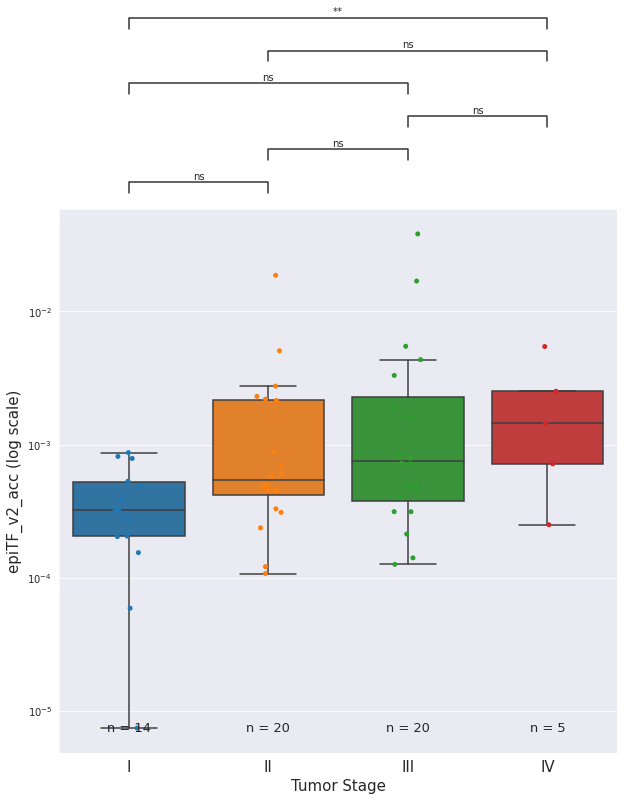

Stage I: n = 14, Median: 4.29e-05, CI: [2.88e-05, 7.37e-05]
Stage II: n = 20, Median: 7.51e-05, CI: [8.71e-05, 4.49e-04]
Stage III: n = 20, Median: 1.00e-04, CI: [-3.69e-04, 2.06e-03]
Stage IV: n = 5, Median: 1.83e-04, CI: [-3.20e-04, 1.50e-03]
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

I vs. II: t-test independent samples, P_val:4.546e-02 t=-2.082e+00
II vs. III: t-test independent samples, P_val:3.311e-01 t=-9.846e-01
III vs. IV: t-test independent samples, P_val:8.323e-01 t=2.142e-01
I vs. III: t-test independent samples, P_val:2.627e-01 t=-1.140e+00
II vs. IV: t-test independent samples, P_val:1.791e-01 t=-1.386e+00
I vs. IV: t-test independent samples, P_val:1.004e-02 t=-2.897e+00


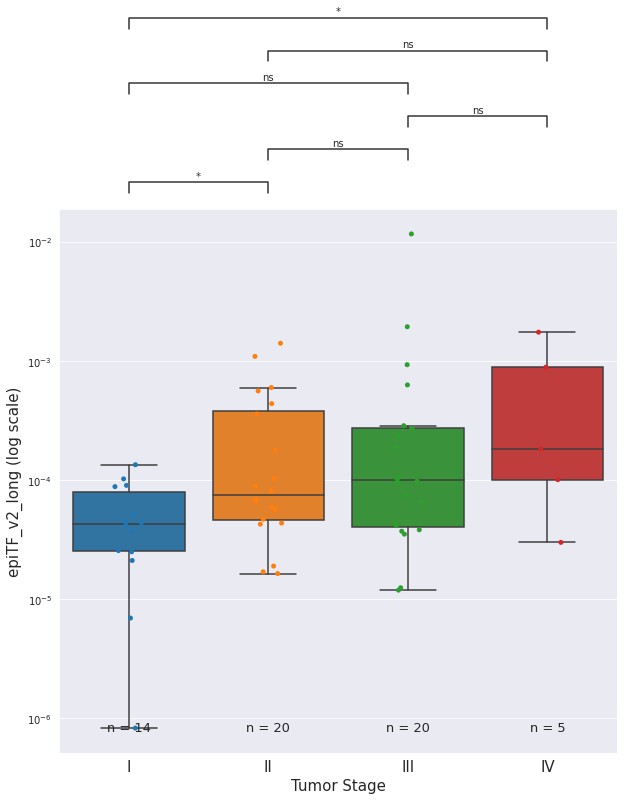

Stage I: n = 14, Median: 4.29e-01, CI: [3.67e-01, 6.40e-01]
Stage II: n = 20, Median: 5.19e-01, CI: [4.87e-01, 7.50e-01]
Stage III: n = 20, Median: 5.11e-01, CI: [4.38e-01, 6.40e-01]
Stage IV: n = 5, Median: 7.17e-01, CI: [3.20e-01, 1.08e+00]
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

I vs. II: t-test independent samples, P_val:2.205e-01 t=-1.250e+00
II vs. III: t-test independent samples, P_val:3.207e-01 t=1.006e+00
III vs. IV: t-test independent samples, P_val:1.780e-01 t=-1.389e+00
I vs. III: t-test independent samples, P_val:6.559e-01 t=-4.497e-01
II vs. IV: t-test independent samples, P_val:5.666e-01 t=-5.814e-01
I vs. IV: t-test independent samples, P_val:1.547e-01 t=-1.490e+00


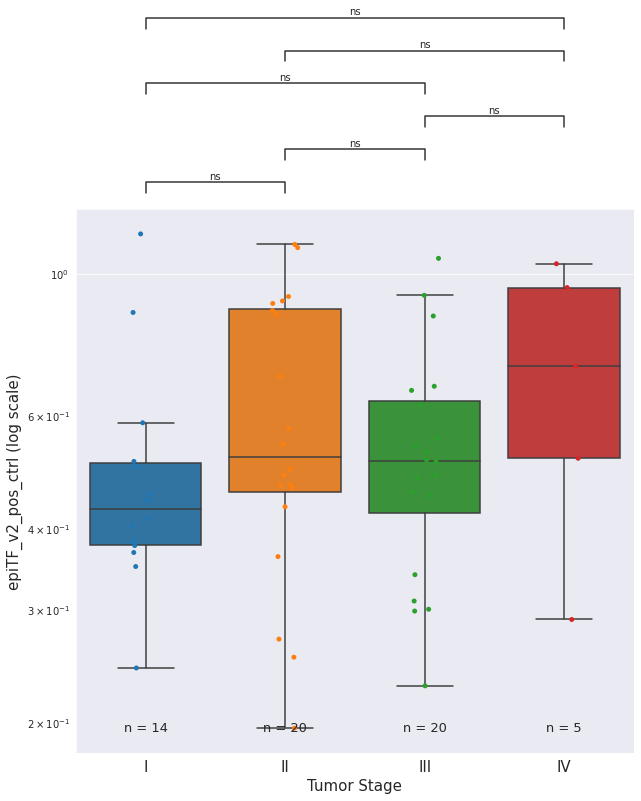

In [21]:
from statannotations.Annotator import Annotator

def boxplot_simple_adjusted(df, x_col):
    fig, ax0 = plt.subplots(nrows=1, figsize=(10, 10)) 

    sns.set_style('darkgrid')
    plot_order = ["I", "II", "III", "IV"]

    # Boxplot
    sns.boxplot(data=df, x="Tumor.stage..simplified.", y=x_col, showfliers=False, order=plot_order, ax=ax0)
    sns.stripplot(data=df, x="Tumor.stage..simplified.", y=x_col, jitter=True, size=5, dodge=True, ax=ax0, linewidth=0.5, edgecolor='none', order=plot_order)  
    
    #This 0.00006 parameter is used to adjust the position of sample n indication
    #This number needs to be adjusted otherwise may encounter ValueError of Image size
    ax0.set_yscale("log")  
    y_offset = df[x_col].min()
    
    stages = df['Tumor.stage..simplified.'].unique()
    for i, stage in enumerate(plot_order):
        subset = df[df['Tumor.stage..simplified.'] == stage]
        n = len(subset)
        median = np.median(subset[x_col])
        ci_low, ci_high = stats.t.interval(0.95, len(subset)-1, loc=np.mean(subset[x_col]), scale=stats.sem(subset[x_col]))
        ax0.text(i, y_offset, f'n = {n}', ha='center', va='center', fontsize=13)
        print(f'Stage {stage}: n = {n}, Median: {median:.2e}, CI: [{ci_low:.2e}, {ci_high:.2e}]')

    pairs = [
        ("I", "II"),
        ("I", "III"),
        ("I", "IV"),
        ("II", "III"),
        ("II", "IV"),
        ("III", "IV")
    ]
    
    annotator = Annotator(ax=ax0, pairs=pairs, data=df, x='Tumor.stage..simplified.', y=x_col, order=plot_order)
    annotator.configure(test='t-test_ind', text_format='star', loc='outside')
    annotator.apply_and_annotate()

    # plt.title(f'{x_col} by Stage on pre-op COSMOS (MB CRC pos & ctDNA detected)', fontsize=15)
    ax0.set_xlabel('Tumor Stage', fontsize=15)
    ax0.set_ylabel(f'{x_col} (log scale)', fontsize=15)
    ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=15)

    plt.show()
    
boxplot_simple_adjusted(df_cosmos_new_pos_detected, 'epiTF_v2_acc')
boxplot_simple_adjusted(df_cosmos_new_pos_detected, 'epiTF_v2_long')
boxplot_simple_adjusted(df_cosmos_new_pos_detected, 'epiTF_v2_pos_ctrl')

In [188]:
# #No need for bonferroni because my null hypothesis is not Familywise Null Hypothesis (H0f): There are no differences between any of the tumor stages being compared across all tests. Instead I treat each comparison as an independent comparison.
# def boxplot_simple_bonferroni_correction(df, x_col):
#     fig, ax0 = plt.subplots(nrows=1, figsize=(10, 10)) 

#     sns.set_style('darkgrid')
#     plot_order = ["I", "II", "III", "IV"]

#     # Boxplot
#     sns.boxplot(data=df, x="Tumor.stage..simplified.", y=x_col, showfliers=False, order=plot_order, ax=ax0)
#     sns.stripplot(data=df, x="Tumor.stage..simplified.", y=x_col, jitter=True, size=5, dodge=True, ax=ax0, linewidth=0.5, edgecolor='none', order=plot_order)  
    
#     ax0.set_yscale("log")  
#     y_offset = df[x_col].min() - 0.00006
    
#     stages = df['Tumor.stage..simplified.'].unique()
#     for i, stage in enumerate(plot_order):
#         subset = df[df['Tumor.stage..simplified.'] == stage]
#         n = len(subset)
#         median = np.median(subset[x_col])
#         ci_low, ci_high = stats.t.interval(0.95, len(subset)-1, loc=np.mean(subset[x_col]), scale=stats.sem(subset[x_col]))
#         ax0.text(i, y_offset, f'n = {n}', ha='center', va='center', fontsize=13)
#         print(f'Stage {stage}: n = {n}, Median: {median:.2e}, CI: [{ci_low:.2e}, {ci_high:.2e}]')

#     pairs = [
#         ("I", "II"),
#         ("I", "III"),
#         ("I", "IV"),
#         ("II", "III"),
#         ("II", "IV"),
#         ("III", "IV")
#     ]
    
#     # Apply Bonferroni correction
#     number_of_tests = len(pairs) 
#     p_value_threshold = 0.05 / number_of_tests
    
#     annotator = Annotator(ax=ax0, pairs=pairs, data=df, x='Tumor.stage..simplified.', y=x_col, order=plot_order)
#     annotator.configure(test='t-test_ind', text_format='star', loc='outside', pvalue_thresholds=[(p_value_threshold, "*"), (0.01, "**"), (0.001, "***"), (0.0001, "****")])
#     annotator.apply_and_annotate()

#     plt.title(f'{x_col} by Stage on pre-op COSMOS (MB CRC pos & ctDNA detected)', fontsize=15)
#     ax0.set_xlabel('Tumor Stage', fontsize=15)
#     ax0.set_ylabel(f'{x_col} (log scale)', fontsize=15)
#     ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=15)

#     plt.show()

    
# boxplot_simple_bonferroni_correction(df_cosmos_new_pos_detected, 'pred_frac_force')

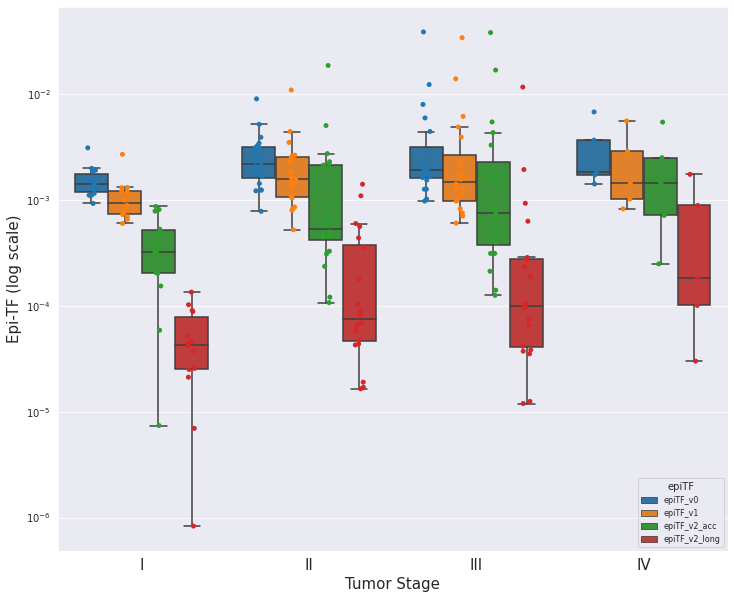

epi_method
epiTF_v0         0.001571
epiTF_v1         0.001388
epiTF_v2_acc     0.001287
epiTF_v2_long    0.000173
Name: value, dtype: float64


In [6]:
def boxplot_with_hue_and_iqr(df, x_col, y_cols, hue_col):
    # Convert 'Tumor.stage..simplified.' to a categorical type with a specified order
    stage_order = ["I", "II", "III", "IV"]
    df['Tumor.stage..simplified.'] = pd.Categorical(df['Tumor.stage..simplified.'], categories=stage_order, ordered=True)

    # Reshape the dataframe
    df_long = df.loc[:, ['Tumor.stage..simplified.'] + y_cols]
    df_long = df_long.melt(id_vars=['Tumor.stage..simplified.'], value_vars=y_cols, 
                           var_name=hue_col, value_name='value')

    # Create the plot
    fig, ax0 = plt.subplots(nrows=1, figsize=(12, 10))
    sns.set_style('darkgrid')
    
    # Boxplot with hue
    sns.boxplot(data=df_long, x="Tumor.stage..simplified.", y='value', hue=hue_col,
                showfliers=False, order=stage_order, ax=ax0)
    sns.stripplot(data=df_long, x="Tumor.stage..simplified.", y='value', hue=hue_col,
                  jitter=True, size=5, dodge=True, ax=ax0, linewidth=0.5, edgecolor='none', order=stage_order)

    ax0.set_yscale("log")
    ax0.legend(title=hue_col)

    ax0.set_xlabel('Tumor Stage', fontsize=15)
    ax0.set_ylabel('Epi-TF (log scale)', fontsize=15)
    ax0.set_xticklabels(stage_order, fontsize=15)

    # Handling the legend to prevent duplication of legend entries
    handles, labels = ax0.get_legend_handles_labels()
    ax0.legend(handles[0:4], labels[0:4], title='epiTF', loc='lower right', fontsize = 8)

    plt.show()
    
    # Calculate average IQR for each subgroup
    iqr_values = df_long.groupby(hue_col)['value'].apply(iqr).reset_index()
    average_iqr = iqr_values.groupby(hue_col)['value'].mean()
    
    return average_iqr

y_cols = ["epiTF_v0", "epiTF_v1", "epiTF_v2_acc", "epiTF_v2_long"]
hue_col = "epi_method"
average_iqr_results = boxplot_with_hue_and_iqr(df_cosmos_new_pos_detected, 'Method Comparison', y_cols, hue_col)
print(average_iqr_results)


## Scatter plot (pairplot) to compare each pair of epiTF methods of pre-op COSMOS across different cancer stage

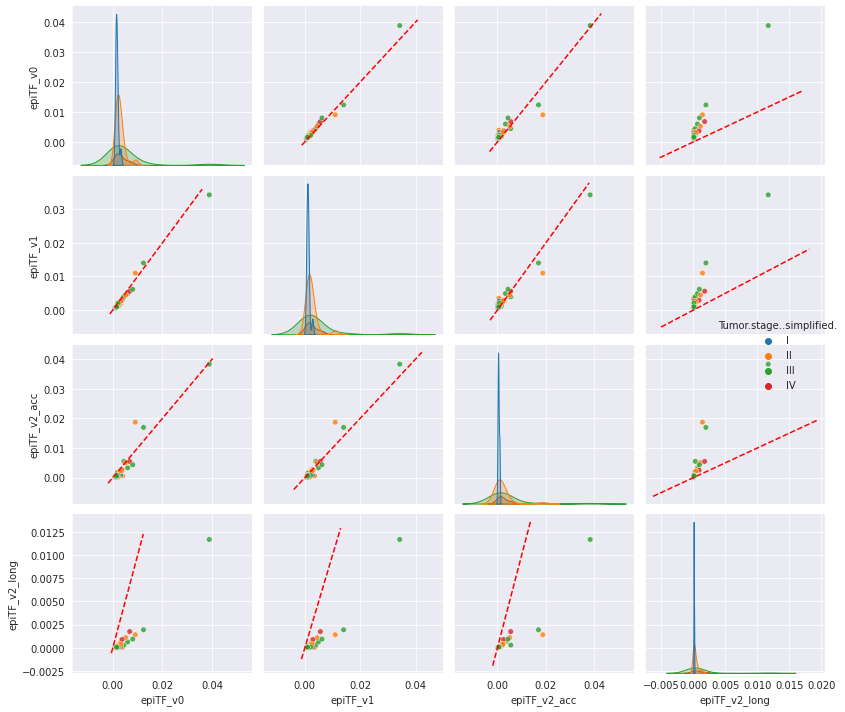

In [25]:
#use pairplot to compare each all epiTF methods by pair
g = sns.pairplot(df_cosmos_new_pos_detected, vars=y_cols, plot_kws={'alpha':0.8, 's':30}, diag_kind='kde', hue='Tumor.stage..simplified.')

for i in range(len(y_cols)):
    for j in range(len(y_cols)):
        if i != j:  # Don't draw a line on the KDE diagonal
            
            x0, x1 = g.axes[i, j].get_xlim()
            y0, y1 = g.axes[i, j].get_ylim()
            min_val = max(x0, y0)
            max_val = min(x1, y1)
            # Plot the line of perfect agreement based on the axes range
            g.axes[i, j].plot([min_val, max_val], [min_val, max_val], 'r--')

# Adjust the layout to prevent overlap
g.fig.tight_layout()
plt.show()

## Parallel coordinates plot to visualize each sample's values across different epiTF methods.

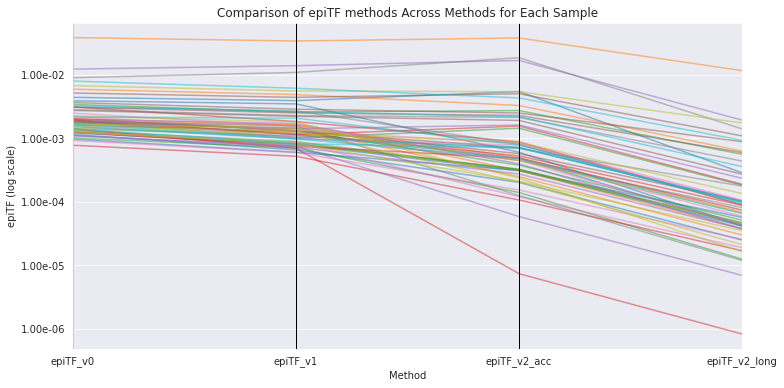

In [7]:
from pandas.plotting import parallel_coordinates

# Select only the columns with the methods' data and the 'sample_id'
df_methods = df_cosmos_new_pos_detected[["sample_id", "epiTF_v0", "epiTF_v1", "epiTF_v2_acc", "epiTF_v2_long"]]

# Plotting parallel coordinates
plt.figure(figsize=(12, 6))
ax = parallel_coordinates(df_methods, class_column='sample_id', colormap=plt.get_cmap("tab10"), alpha=0.5)

# Set y-ticks to log scale
ax.set_yscale('log')
y_vals = ax.get_yticks()
ax.set_yticklabels(['{:.2e}'.format(y) for y in y_vals])

# Remove the legend
plt.legend([], [], frameon=False)
plt.xlabel('Method')
plt.ylabel('epiTF (log scale)')
plt.title('Comparison of epiTF methods Across Methods for Each Sample')
plt.grid(True)
plt.show()

## Scatter plot with regression line and Pearson correlation coefficient between epiTF and MB CRC score / max-maf

Pearson correlation between epiTF_v0 and methyl_score_MB_CRC: 0.688, p-value: 1.68e-09
Spearman correlation between epiTF_v0 and methyl_score_MB_CRC: 0.645, p-value: 3.45e-08


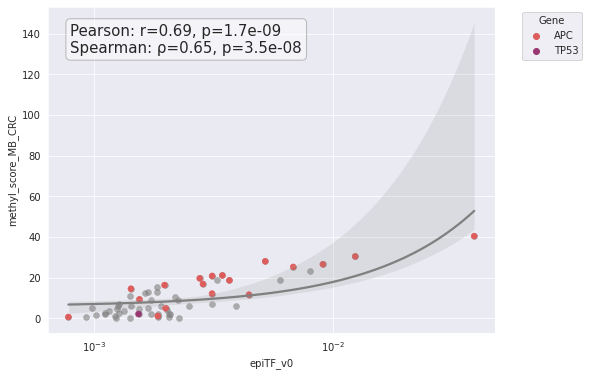

Pearson correlation between epiTF_v1 and methyl_score_MB_CRC: 0.704, p-value: 5.03e-10
Spearman correlation between epiTF_v1 and methyl_score_MB_CRC: 0.632, p-value: 8.16e-08


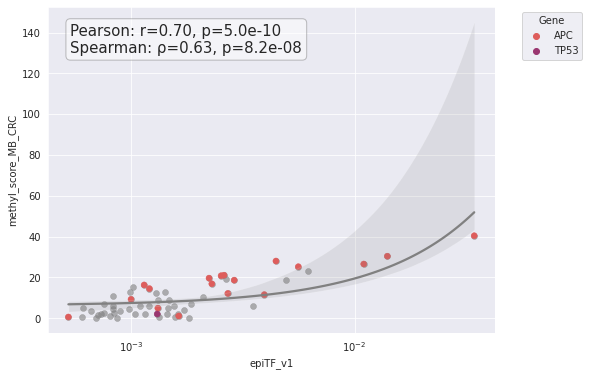

Pearson correlation between epiTF_v2_acc and methyl_score_MB_CRC: 0.727, p-value: 7.18e-11
Spearman correlation between epiTF_v2_acc and methyl_score_MB_CRC: 0.904, p-value: 1.06e-22


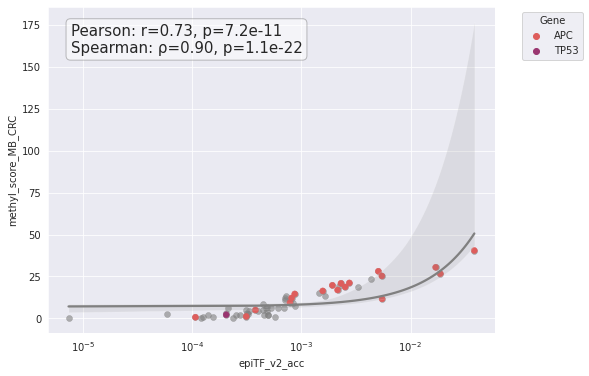

Pearson correlation between epiTF_v2_long and methyl_score_MB_CRC: 0.633, p-value: 7.37e-08
Spearman correlation between epiTF_v2_long and methyl_score_MB_CRC: 0.897, p-value: 6.35e-22


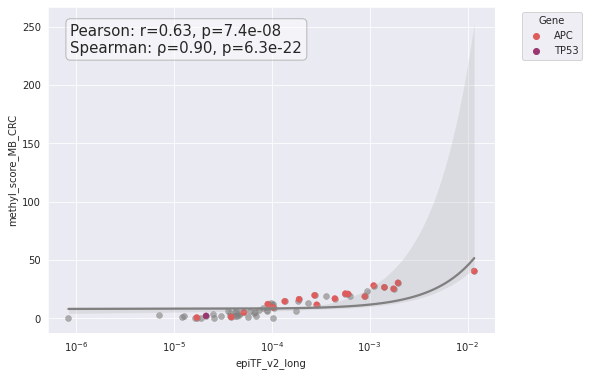

({'epiTF_v0': 0.6884648462380621,
  'epiTF_v1': 0.7038508341404084,
  'epiTF_v2_acc': 0.7267762300332098,
  'epiTF_v2_long': 0.6332143790897372},
 {'epiTF_v0': 1.678269068466296e-09,
  'epiTF_v1': 5.026410148719618e-10,
  'epiTF_v2_acc': 7.183741488322189e-11,
  'epiTF_v2_long': 7.372812822493934e-08},
 {'epiTF_v0': 0.6452367036820573,
  'epiTF_v1': 0.6315604909409702,
  'epiTF_v2_acc': 0.9040327293980129,
  'epiTF_v2_long': 0.8974868497954415},
 {'epiTF_v0': 3.454250582019755e-08,
  'epiTF_v1': 8.16259684138329e-08,
  'epiTF_v2_acc': 1.0605057080812597e-22,
  'epiTF_v2_long': 6.34778905404366e-22})

In [12]:
def analyze_and_plot_correlation(df, x_cols, y_col):
    correlations = {}
    spearman_correlations = {}
    p_values = {}
    spearman_p_values = {}

    for x_col in x_cols:
        # Check if both columns have at least 2 elements
        if len(df[x_col]) < 2 or len(df[y_col]) < 2:
            print(f"Insufficient data for {x_col} and {y_col}. Skipping.")
            continue

        # Calculate the Pearson correlation coefficient and p-value
        pearson_corr, pearson_p_val = scipy.stats.pearsonr(df[x_col], df[y_col])
        correlations[x_col] = pearson_corr
        p_values[x_col] = pearson_p_val

        # Calculate the Spearman correlation coefficient and p-value
        spearman_corr, spearman_p_val = scipy.stats.spearmanr(df[x_col], df[y_col])
        spearman_correlations[x_col] = spearman_corr
        spearman_p_values[x_col] = spearman_p_val

        # Print the correlation results
        print(f"Pearson correlation between {x_col} and {y_col}: {pearson_corr:.3f}, p-value: {pearson_p_val:.3g}")
        print(f"Spearman correlation between {x_col} and {y_col}: {spearman_corr:.3f}, p-value: {spearman_p_val:.3g}")

        # Create scatter plot
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=x_col, y=y_col, data=df, color="gray", alpha=0.6, edgecolor=None)
        
        # Overlay color-coded scatter plot for non-NaN 'Gene' values
        non_nan_df = df.dropna(subset=["Gene"])
        sns.scatterplot(x=x_col, y=y_col, data=non_nan_df, hue="Gene", palette="flare", edgecolor=None)

        # Draw regression line without scatter points
        sns.regplot(x=x_col, y=y_col, data=df, scatter=False, color="gray")

        plt.xscale('log')
        plt.xlabel(x_col)
        # plt.ylabel(y_col)
        plt.legend(title='Gene', bbox_to_anchor=(1.05, 1), loc='upper left')

        # Add text annotation for Pearson and Spearman correlation
        plt.text(0.05, 0.95, f'Pearson: r={pearson_corr:.2f}, p={pearson_p_val:.1e}\nSpearman: ρ={spearman_corr:.2f}, p={spearman_p_val:.1e}',
                 ha='left', va='top', transform=plt.gca().transAxes, fontsize=15, bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='white', alpha=0.5))

        plt.show()

    return correlations, p_values, spearman_correlations, spearman_p_values

# call the function
epiTF_cols = ["epiTF_v0", "epiTF_v1", "epiTF_v2_acc", "epiTF_v2_long"]
analyze_and_plot_correlation(df_cosmos_new_pos_detected, epiTF_cols, 'methyl_score_MB_CRC')


Overall Pearson correlation between epiTF_v0 and methyl_score_MB_CRC: 0.688, p-value: 1.68e-09
Overall Spearman correlation between epiTF_v0 and methyl_score_MB_CRC: 0.645, p-value: 3.45e-08


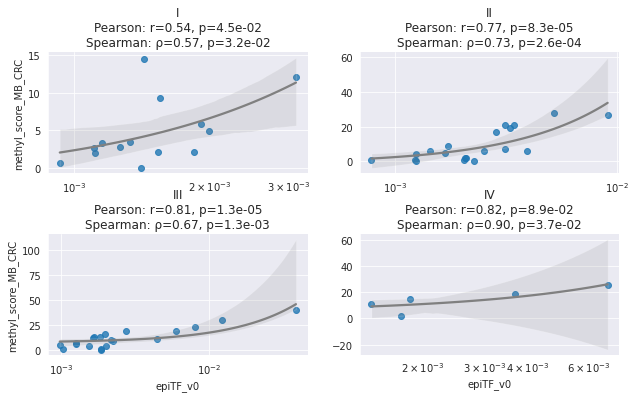

Overall Pearson correlation between epiTF_v1 and methyl_score_MB_CRC: 0.704, p-value: 5.03e-10
Overall Spearman correlation between epiTF_v1 and methyl_score_MB_CRC: 0.632, p-value: 8.16e-08


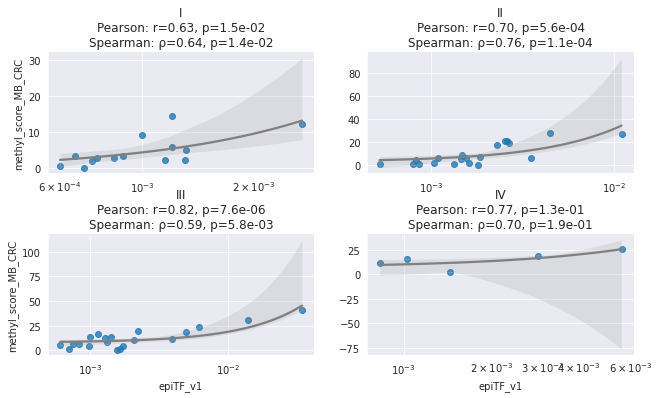

Overall Pearson correlation between epiTF_v2_acc and methyl_score_MB_CRC: 0.727, p-value: 7.18e-11
Overall Spearman correlation between epiTF_v2_acc and methyl_score_MB_CRC: 0.904, p-value: 1.06e-22


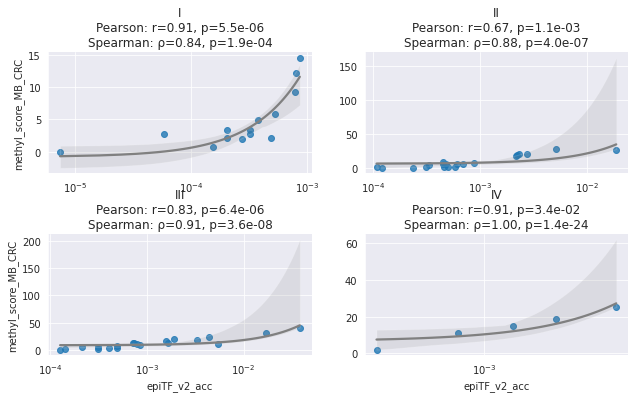

Overall Pearson correlation between epiTF_v2_long and methyl_score_MB_CRC: 0.633, p-value: 7.37e-08
Overall Spearman correlation between epiTF_v2_long and methyl_score_MB_CRC: 0.897, p-value: 6.35e-22


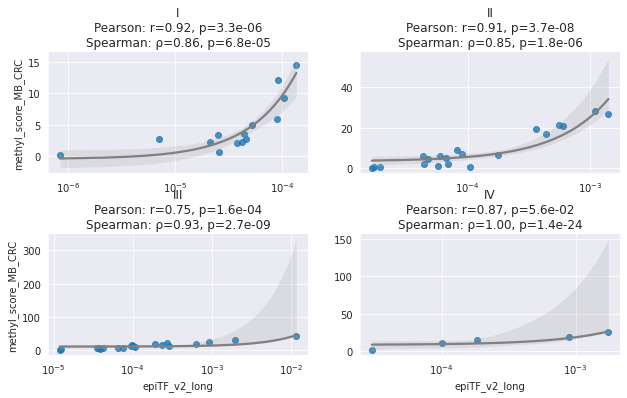

In [16]:
def analyze_and_plot_correlation_stratified(df, x_cols, y_col, stratify_col):
    # Define the order of categories
    stage_order = ["I", "II", "III", "IV"]
    # Convert the 'Tumor.stage..simplified.' column to a categorical type with the specified order
    df[stratify_col] = pd.Categorical(df[stratify_col], categories=stage_order, ordered=True)

    for x_col in x_cols:
        # Calculate Pearson and Spearman correlation coefficient for the entire dataset
        pearson_corr, pearson_p_val = scipy.stats.pearsonr(df[x_col], df[y_col])
        spearman_corr, spearman_p_val = scipy.stats.spearmanr(df[x_col], df[y_col])
        print(f"Overall Pearson correlation between {x_col} and {y_col}: {pearson_corr:.3f}, p-value: {pearson_p_val:.3g}")
        print(f"Overall Spearman correlation between {x_col} and {y_col}: {spearman_corr:.3f}, p-value: {spearman_p_val:.3g}")

        # Create a FacetGrid for each level of the stratify column with the specified order
        g = sns.FacetGrid(df, col=stratify_col, col_wrap=2, height=3, aspect=1.5, sharex=False, sharey=False, col_order=stage_order)
        # Map the scatter plots to the FacetGrid
        g.map(sns.regplot, x_col, y_col, line_kws={'color': 'gray'})
        
        # Set log scale and adjust titles and labels
        g.set(xscale="log")
        g.fig.subplots_adjust(top=0.8, hspace=0.5, wspace=0.2)
        g.set_axis_labels(x_col, y_col)

        # Iterate through axes to calculate Pearson and Spearman correlation for each subset
        for ax, stage in zip(g.axes.flatten(), stage_order):
            stage_df = df[df[stratify_col] == stage]
            if not stage_df.empty:  # Check if the subset is not empty
                stage_pearson_corr, stage_pearson_p_val = scipy.stats.pearsonr(stage_df[x_col], stage_df[y_col])
                stage_spearman_corr, stage_spearman_p_val = scipy.stats.spearmanr(stage_df[x_col], stage_df[y_col])
                # Include both Pearson and Spearman results in the title
                ax.set_title(f'{stage}\nPearson: r={stage_pearson_corr:.2f}, p={stage_pearson_p_val:.1e}\nSpearman: ρ={stage_spearman_corr:.2f}, p={stage_spearman_p_val:.1e}')
            
        plt.show()

# Note: Replace 'df_cosmos_new_pos_detected' and 'Tumor.stage..simplified.' with the appropriate DataFrame and column names from your data.
epiTF_cols = ["epiTF_v0", "epiTF_v1", "epiTF_v2_acc", "epiTF_v2_long"]
stratify_col = "Tumor.stage..simplified." 
analyze_and_plot_correlation_stratified(df_cosmos_new_pos_detected, epiTF_cols, 'methyl_score_MB_CRC', stratify_col)


Pearson correlation between epiTF_v0 and max_maf: -0.047, p-value: 0.725
Spearman correlation between epiTF_v0 and max_maf: 0.074, p-value: 0.577


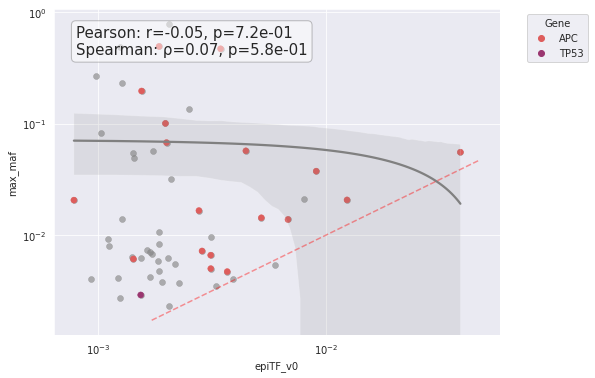

Pearson correlation between epiTF_v1 and max_maf: -0.054, p-value: 0.686
Spearman correlation between epiTF_v1 and max_maf: 0.031, p-value: 0.817


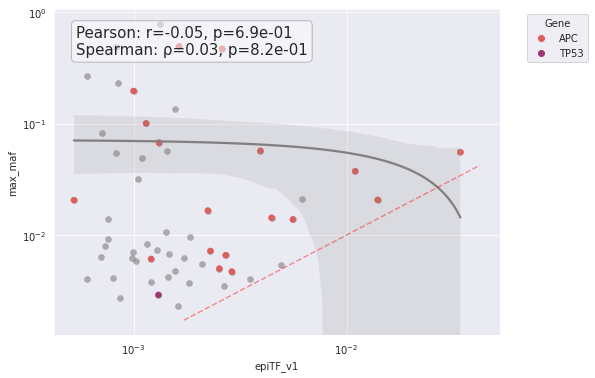

Pearson correlation between epiTF_v2_acc and max_maf: -0.047, p-value: 0.725
Spearman correlation between epiTF_v2_acc and max_maf: 0.186, p-value: 0.158


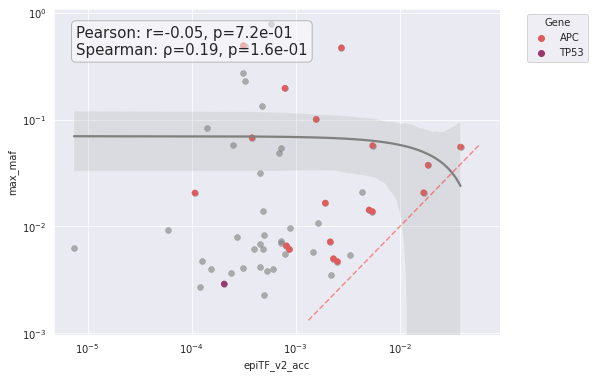

Pearson correlation between epiTF_v2_long and max_maf: -0.031, p-value: 0.816
Spearman correlation between epiTF_v2_long and max_maf: 0.201, p-value: 0.127


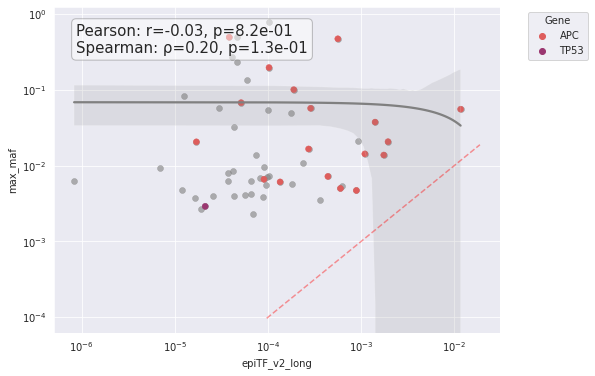

({'epiTF_v0': -0.04679639982449337,
  'epiTF_v1': -0.05371022670554243,
  'epiTF_v2_acc': -0.04685631897515313,
  'epiTF_v2_long': -0.030891411122759612},
 {'epiTF_v0': 0.7248742213552868,
  'epiTF_v1': 0.6861973978199971,
  'epiTF_v2_acc': 0.7245359058106619,
  'epiTF_v2_long': 0.8163361387992093},
 {'epiTF_v0': 0.0740632501012658,
  'epiTF_v1': 0.030718419832845446,
  'epiTF_v2_acc': 0.18638569293440096,
  'epiTF_v2_long': 0.20091191049569895},
 {'epiTF_v0': 0.5771960020909646,
  'epiTF_v1': 0.8173469226562409,
  'epiTF_v2_acc': 0.1575252910795681,
  'epiTF_v2_long': 0.12705479515985565})

In [18]:
#Scatter plot with regression line and Pearson correlation coefficient between epiTF and max-maf (column "Max_percentage" from TB)
df_cosmos_new_pos_detected["max_maf"] = df_cosmos_new_pos_detected["Max_percentage"] / 100

#get TVF filtered somatic variant maf
df_cosmos_new_pos_detected_tvf["tvf_max_maf"] = df_cosmos_new_pos_detected_tvf["TVF_Percentage"] / 100

def analyze_and_plot_correlation_MAXmaf(df, x_cols, y_col):
    correlations = {}
    spearman_correlations = {}  # To store Spearman correlations
    p_values = {}
    spearman_p_values = {}  # To store Spearman p-values

    for x_col in x_cols:
        # Check if both columns have at least 2 elements
        if len(df[x_col]) < 2 or len(df[y_col]) < 2:
            print(f"Insufficient data for {x_col} and {y_col}. Skipping.")
            continue

        # Calculate the Pearson correlation coefficient and p-value
        pearson_corr, pearson_p_val = scipy.stats.pearsonr(df[x_col], df[y_col])
        correlations[x_col] = pearson_corr
        p_values[x_col] = pearson_p_val

        # Calculate the Spearman correlation coefficient and p-value
        spearman_corr, spearman_p_val = scipy.stats.spearmanr(df[x_col], df[y_col])
        spearman_correlations[x_col] = spearman_corr
        spearman_p_values[x_col] = spearman_p_val

        # Print the correlation results
        print(f"Pearson correlation between {x_col} and {y_col}: {pearson_corr:.3f}, p-value: {pearson_p_val:.3g}")
        print(f"Spearman correlation between {x_col} and {y_col}: {spearman_corr:.3f}, p-value: {spearman_p_val:.3g}")
        
        # Create scatter plot for all data points with a default color (e.g., gray for NaN 'Gene' values)
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=x_col, y=y_col, data=df, color="gray", alpha=0.6, edgecolor=None)

        # Overlay color-coded scatter plot for non-NaN 'Gene' values
        # This uses dropna to filter the dataframe to only those rows where 'Gene' is not NaN
        non_nan_df = df.dropna(subset=["Gene"])
        sns.scatterplot(x=x_col, y=y_col, data=non_nan_df, hue="Gene", palette="flare", edgecolor=None)

        # Draw regression line without scatter points
        sns.regplot(x=x_col, y=y_col, data=df, scatter=False, color="gray")
        
        plt.xscale('log')
        plt.yscale('log')
        
        # Add a diagonal line (y = x)
        x_lims = plt.xlim()
        y_lims = plt.ylim()
        min_val = max(x_lims[0], y_lims[0])
        max_val = min(x_lims[1], y_lims[1])
        plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", alpha=0.4)

        # Add text annotation for Pearson and Spearman correlation
        plt.text(0.05, 0.95, f'Pearson: r={pearson_corr:.2f}, p={pearson_p_val:.1e}\nSpearman: ρ={spearman_corr:.2f}, p={spearman_p_val:.1e}',
                 ha='left', va='top', transform=plt.gca().transAxes, fontsize=15, bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='white', alpha=0.5))


        plt.xlabel(x_col)
        plt.ylabel(y_col)
        plt.legend(title='Gene', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

    return correlations, p_values, spearman_correlations, spearman_p_values


#call the function
epiTF_cols = ["epiTF_v0", "epiTF_v1", "epiTF_v2_acc", "epiTF_v2_long"]
analyze_and_plot_correlation_MAXmaf(df_cosmos_new_pos_detected, epiTF_cols, 'max_maf')


Pearson correlation between epiTF_v0 and tvf_max_maf: 0.755, p-value: 0.000186
Spearman correlation between epiTF_v0 and tvf_max_maf: 0.812, p-value: 2.39e-05


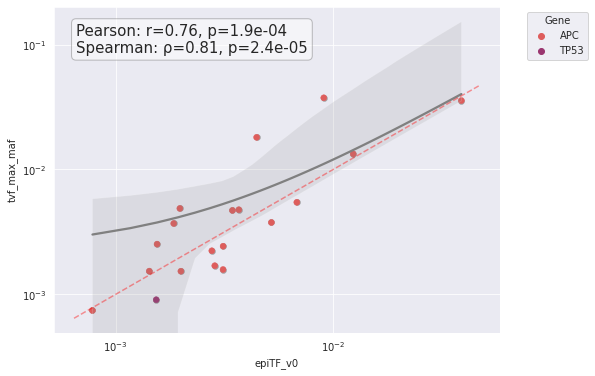

Pearson correlation between epiTF_v1 and tvf_max_maf: 0.802, p-value: 3.66e-05
Spearman correlation between epiTF_v1 and tvf_max_maf: 0.740, p-value: 0.000289


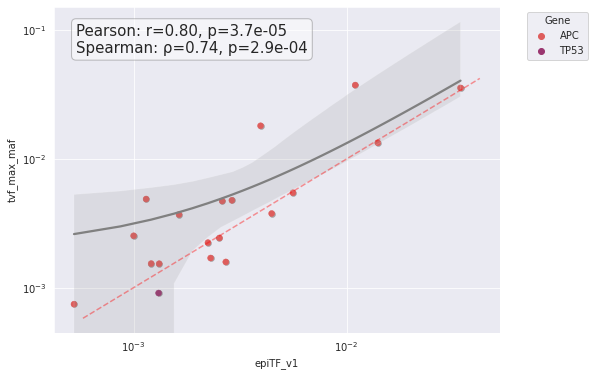

Pearson correlation between epiTF_v2_acc and tvf_max_maf: 0.883, p-value: 5.54e-07
Spearman correlation between epiTF_v2_acc and tvf_max_maf: 0.863, p-value: 1.96e-06


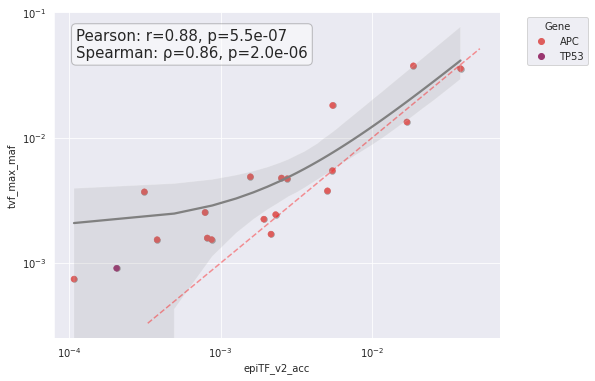

Pearson correlation between epiTF_v2_long and tvf_max_maf: 0.687, p-value: 0.00116
Spearman correlation between epiTF_v2_long and tvf_max_maf: 0.788, p-value: 6.23e-05


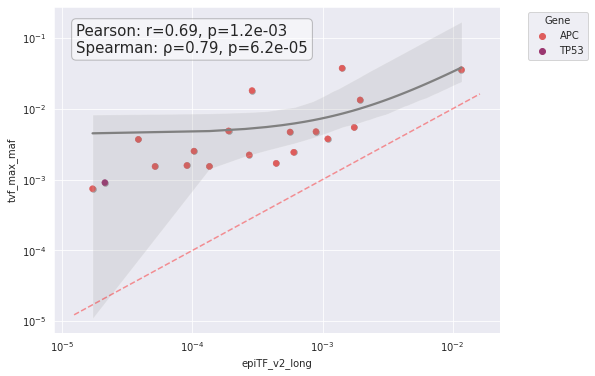

({'epiTF_v0': 0.7550646337471281,
  'epiTF_v1': 0.8017636538867211,
  'epiTF_v2_acc': 0.8830155615580129,
  'epiTF_v2_long': 0.6869104674145966},
 {'epiTF_v0': 0.0001861480014922388,
  'epiTF_v1': 3.6628095478969636e-05,
  'epiTF_v2_acc': 5.539295258533903e-07,
  'epiTF_v2_long': 0.0011589014987322822},
 {'epiTF_v0': 0.8122807017543859,
  'epiTF_v1': 0.7403508771929824,
  'epiTF_v2_acc': 0.863157894736842,
  'epiTF_v2_long': 0.787719298245614},
 {'epiTF_v0': 2.3945514344456727e-05,
  'epiTF_v1': 0.00028927201601490195,
  'epiTF_v2_acc': 1.957499940679194e-06,
  'epiTF_v2_long': 6.225179850049195e-05})

In [11]:
#TVF filtered assoication analysis between somatic max-maf and epiTF methods
analyze_and_plot_correlation_MAXmaf(df_cosmos_new_pos_detected_tvf, epiTF_cols, 'tvf_max_maf')

Pearson correlation between max_maf and methyl_score_MB_CRC: -0.122, p-value: 0.358
Spearman correlation between max_maf and methyl_score_MB_CRC: 0.131, p-value: 0.325


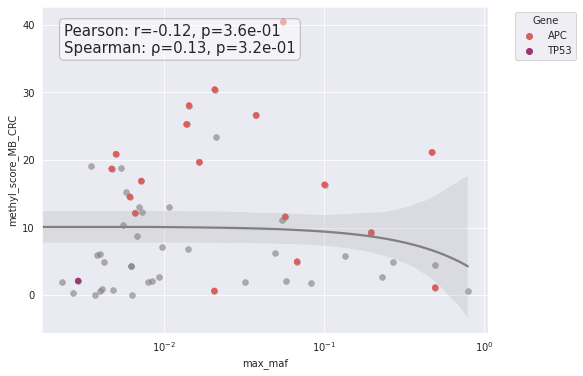

Pearson correlation between tvf_max_maf and methyl_score_MB_CRC: 0.605, p-value: 0.00611
Spearman correlation between tvf_max_maf and methyl_score_MB_CRC: 0.674, p-value: 0.00157


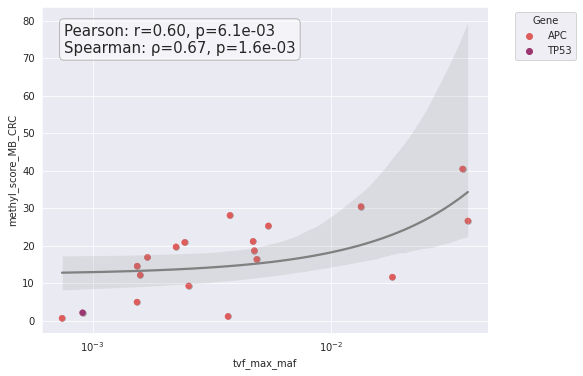

({'tvf_max_maf': 0.6045707632899173},
 {'tvf_max_maf': 0.006107466710842808},
 {'tvf_max_maf': 0.6736842105263158},
 {'tvf_max_maf': 0.001565449761605664})

In [12]:
#coorelation between max-maf and MB CRC score
epiTF_cols = ["max_maf"]
analyze_and_plot_correlation(df_cosmos_new_pos_detected, epiTF_cols, 'methyl_score_MB_CRC')

#coorelation between TVF max-maf and MB CRC score
epiTF_cols = ["tvf_max_maf"]
analyze_and_plot_correlation(df_cosmos_new_pos_detected_tvf, epiTF_cols, 'methyl_score_MB_CRC')

In [71]:
df_cosmos_new_pos_detected_tvf["Tumor.stage..simplified."].value_counts()

III    6
II     6
I      5
IV     2
Name: Tumor.stage..simplified., dtype: int64

In [72]:
df_cosmos_new_pos_detected_tvf["TVF_Gene"].value_counts()

APC     18
TP53     1
Name: TVF_Gene, dtype: int64